<h1><center>Advanced Machine Learning Methods - Project</center></h1>

<h2><center>By: Yahya Bushara Abdalla Abdelrahem</center></h2>

For the advanced machine learning methods project, I decided to take a MNIST-like data set that contains images of the letters of the American Sign Language (ASL). My goal for this project is to create a convolutional neural network using pytorch and implement the necessary preprocessing techniques to achieve a model accuracy of at least 80% (many solutions for this problem have managed to achieve 80% accuracy, some even 100%). The data set consists of two CSV files (one for training and one for testing) containing a table with 784 columns (1 for each pixel of a 28x28 image). Each row represents a different image and the value of the columns represent the greyscale value of each pixel. I do not plan on using transfer learning for this project, but rather training my convolutional neural network from scratch. 

# Part I

## Exploratory Data Analysis

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv("sign_mnist_train.csv")

print(train_df.shape)

(27455, 785)


In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
test_df = pd.read_csv("sign_mnist_test.csv")

print(test_df.shape)

(7172, 785)


There are a total 34,627 images in the data set - 7172 images are used for test which puts the test train split at roughly 80:20 (or more accurately 79.29:20.71). 

In [5]:
print("Labels - ",sorted(train_df['label'].unique()))

print(f"\nNumber of labels: {len(train_df['label'].unique())}")

Labels -  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

Number of labels: 24


* Notice, there are only 24 labels (9 and 25 are missing) even though ASL has 26 letters. The letters *J* and *Z* are excluded because they require movement to sign and consequently detect. Moreover, *J* looks similar to *I* and *Z* to *D* which could throw off training the model.

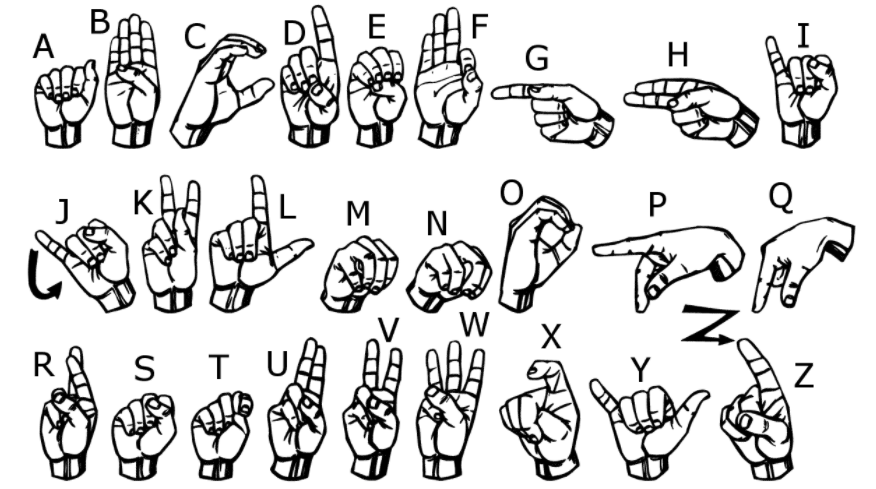

In [6]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
                     'W', 'X', 'Y','Z']

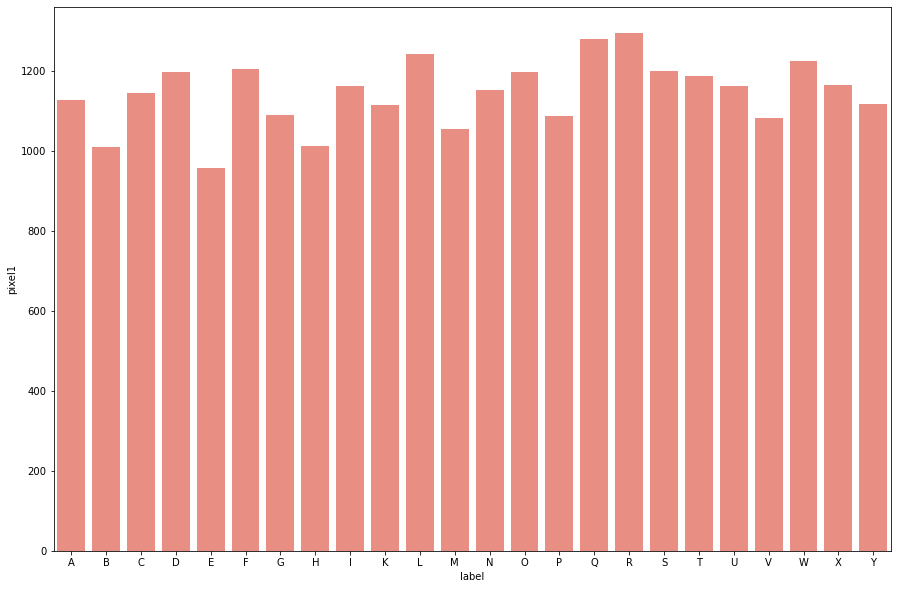

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

train_label_count = pd.DataFrame(data = train_df.groupby("label")['pixel1'].count().reset_index())

train_label_count['label'] = train_label_count['label'].apply(lambda x: letters[x])

plt.figure(figsize=(15, 10))

train_label_barplot = sns.barplot(data = train_label_count, x = 'label', y = 'pixel1', color='salmon')

In [8]:
avg = train_label_count['pixel1'].mean()
e_count = train_label_count.query("label == 'E'")['pixel1'].values[0]
relative_difference = ((e_count - avg) / avg) * 100

print(f"""There are 957 images with the label E. The average frequency per label is {avg} which means the frequency of the label E differs from the average by {relative_difference}%""")

There are 957 images with the label E. The average frequency per label is 1143.9583333333333 which means the frequency of the label E differs from the average by -16.3431069022036%


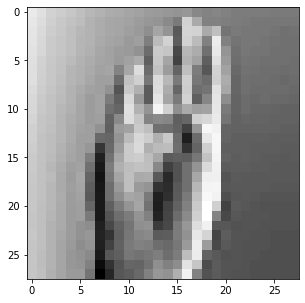

In [9]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

image = train_df.loc[random.randint(0, 27455), 'pixel1':].values.reshape((28, 28)) 
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='Greys')

As you can see, an image with only 784 pixels (28x28) is grainy and of relatively low resolution. I might have to use a MaxPool filter with a small kernel size to avoid over-downsampling. Next, I am going to calculate mean and standard deviation of the pixel values of the train data set. I will also do the same for the test data set since the distribution of its pixel values might differ.

In [10]:
import numpy as np

In [11]:
def calculate_train_mean_std_test_mean_std(train_df, test_df):
    train_mean = train_df.loc[:, 'pixel1':].sum().sum() / (27455 * 784)
    
    train_variance = train_df.loc[:, 'pixel1':] - train_mean

    train_variance = train_variance * train_variance

    train_variance = train_variance.sum().sum()

    train_variance = train_variance / (27455 * 784)

    train_std = np.sqrt(train_variance)
    
    test_mean = test_df.loc[:, 'pixel1':].sum().sum() / (7172 * 784)
    
    test_variance = test_df.loc[:, 'pixel1':] - train_mean

    test_variance = test_variance * test_variance

    test_variance = test_variance.sum().sum()

    test_variance = test_variance / (7172 * 784)

    test_std = np.sqrt(test_variance)
    
    return train_mean, train_std, test_mean, test_std

In [12]:
train_mean, train_std, test_mean, test_std = calculate_train_mean_std_test_mean_std(train_df, test_df)

## Approach to solving the problem

My plan is to perform grayscale normalization on the train and test data sets since convolutional neural networks converge faster when the range of the data is reduced to [0 - 1]. Afterwards, I shall load the data sets into a DataLoader and build my first CNN using torch.nn.Sequential to create my layers (for the first iteration, I shall include only convolutional, activation, and fully connected layers). After testing out the first attempt of the model, if the results are not satisfactory then I will add non-linear layers (MaxPool), experiment with the hyperparameters (learning rate, stride, kernel size), and regularization techniques (such as dropout). 

# Part 2

## Data preparation

The data set that I found on Kaggle was already split up into two parts (for training and validation), and since we have also determined in the previous stage that the train-test split is 80:20 and that there aren't any large class imbalances, there isn't a need to combine the train and test data sets, shuffle them up and create my own split. I am going to start the data preparation by performing grayscale normalization (which is reducing the input channel's range from [0 - 255] to [0 - 1]).

In [13]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [14]:
for column in train_df.columns:
    if column != 'label':
        train_df[column] = train_df[column].apply(lambda x: x / 255)
        
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,0.419608,0.462745,0.498039,0.525490,0.545098,0.560784,0.572549,0.588235,0.600000,...,0.811765,0.811765,0.811765,0.811765,0.807843,0.807843,0.807843,0.800000,0.796078,0.792157
1,6,0.607843,0.615686,0.611765,0.611765,0.611765,0.615686,0.611765,0.619608,0.619608,...,0.270588,0.584314,0.501961,0.341176,0.368627,0.639216,0.686275,0.403922,0.529412,0.584314
2,2,0.733333,0.737255,0.737255,0.733333,0.733333,0.729412,0.733333,0.737255,0.733333,...,0.792157,0.788235,0.784314,0.780392,0.776471,0.780392,0.776471,0.764706,0.760784,0.764706
3,2,0.827451,0.827451,0.831373,0.831373,0.827451,0.823529,0.827451,0.823529,0.823529,...,0.921569,0.917647,0.913725,0.905882,0.901961,0.886275,0.882353,0.870588,0.898039,0.639216
4,13,0.643137,0.654902,0.666667,0.674510,0.690196,0.701961,0.705882,0.721569,0.725490,...,0.360784,0.411765,0.411765,0.423529,0.521569,0.639216,0.615686,0.639216,0.643137,0.701961


In [15]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [16]:
for column in test_df.columns:
    if column != 'label':
        test_df[column] = test_df[column].apply(lambda x: x / 255)

In [17]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,0.584314,0.584314,0.588235,0.588235,0.588235,0.592157,0.592157,0.588235,0.592157,...,0.541176,0.580392,0.498039,0.349020,0.321569,0.376471,0.415686,0.439216,0.470588,0.419608
1,5,0.494118,0.501961,0.513725,0.517647,0.521569,0.525490,0.529412,0.529412,0.533333,...,0.184314,0.407843,0.760784,0.717647,0.729412,0.721569,0.721569,0.721569,0.713725,0.705882
2,10,0.333333,0.345098,0.360784,0.376471,0.411765,0.482353,0.529412,0.560784,0.576471,...,0.266667,0.650980,0.949020,0.890196,0.901961,0.890196,0.886275,0.882353,0.878431,0.870588
3,0,0.796078,0.803922,0.811765,0.807843,0.811765,0.819608,0.823529,0.819608,0.823529,...,0.603922,0.972549,0.968627,0.972549,0.992157,0.925490,0.901961,0.941176,0.992157,1.000000
4,3,0.737255,0.749020,0.756863,0.764706,0.780392,0.788235,0.792157,0.796078,0.796078,...,0.101961,0.156863,0.250980,0.188235,0.113725,0.180392,0.192157,0.180392,0.180392,0.207843


In [18]:
train_mean, train_std, test_mean, test_std = calculate_train_mean_std_test_mean_std(train_df, test_df)

In [19]:
train_df['label'] = train_df['label'].apply(lambda x: letters[x])
test_df['label'] = test_df['label'].apply(lambda x: letters[x])
classes = sorted(set(train_df['label'].values.tolist()))
class_to_idx = {letter:i for i, letter in enumerate(classes)}

class_to_idx

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'O': 13,
 'P': 14,
 'Q': 15,
 'R': 16,
 'S': 17,
 'T': 18,
 'U': 19,
 'V': 20,
 'W': 21,
 'X': 22,
 'Y': 23}

In [20]:
train_df['label'] = train_df['label'].apply(lambda x: class_to_idx[x])
test_df['label'] = test_df['label'].apply(lambda x: class_to_idx[x])

In [21]:
import torch.utils.data as data_utils
import torch

train_target = train_df['label'].values
train_features = train_df.drop('label', axis=1).values.reshape(train_df.shape[0], 1, 28, 28)

train_data = data_utils.TensorDataset(torch.tensor(train_features, dtype=torch.double), torch.tensor(train_target , dtype=torch.long))

In [22]:
test_target = test_df['label'].values 
test_features = test_df.drop('label', axis=1).values.reshape(test_df.shape[0], 1, 28, 28)

test_data = data_utils.TensorDataset(torch.tensor(test_features, dtype=torch.double), torch.tensor(test_target, dtype=torch.long))

Unfortunately, since I took this approach towards creating my data set for model training and evaluation I cannot pass torch's built-in transforms. A quick google search revealed that an easy way to solve this issue is to create your own custom Dataset class that inherits from torch's native Dataset class.  

In [23]:
class TransformedTensorDataset(data_utils.Dataset):
    def __init__(self, untransformed_dataset, transform=None):
        self.raw_data = untransformed_dataset
        self.transform = transform
        
    def __getitem__(self, index):
        input_data, label = self.raw_data[index]
        if self.transform:
            input_data = self.transform(input_data)
        return input_data.to('cuda'), label.to('cuda')
    
    def __len__(self):
        return len(self.raw_data)

In [24]:
from torchvision import transforms

train_transforms = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
                                       transforms.ColorJitter(brightness=.5, hue=.3),
                                       transforms.RandomInvert(),
                                       transforms.Normalize([train_mean], [train_std]),
                                       transforms.ConvertImageDtype(torch.double)])

test_transforms = transforms.Compose([transforms.Normalize([test_mean], [test_std]),
                                      transforms.ConvertImageDtype(torch.double)])

train_transformed = TransformedTensorDataset(train_data, train_transforms)
test_transformed = TransformedTensorDataset(test_data, test_transforms)

trainloader = torch.utils.data.DataLoader(train_transformed, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_transformed, batch_size=64)

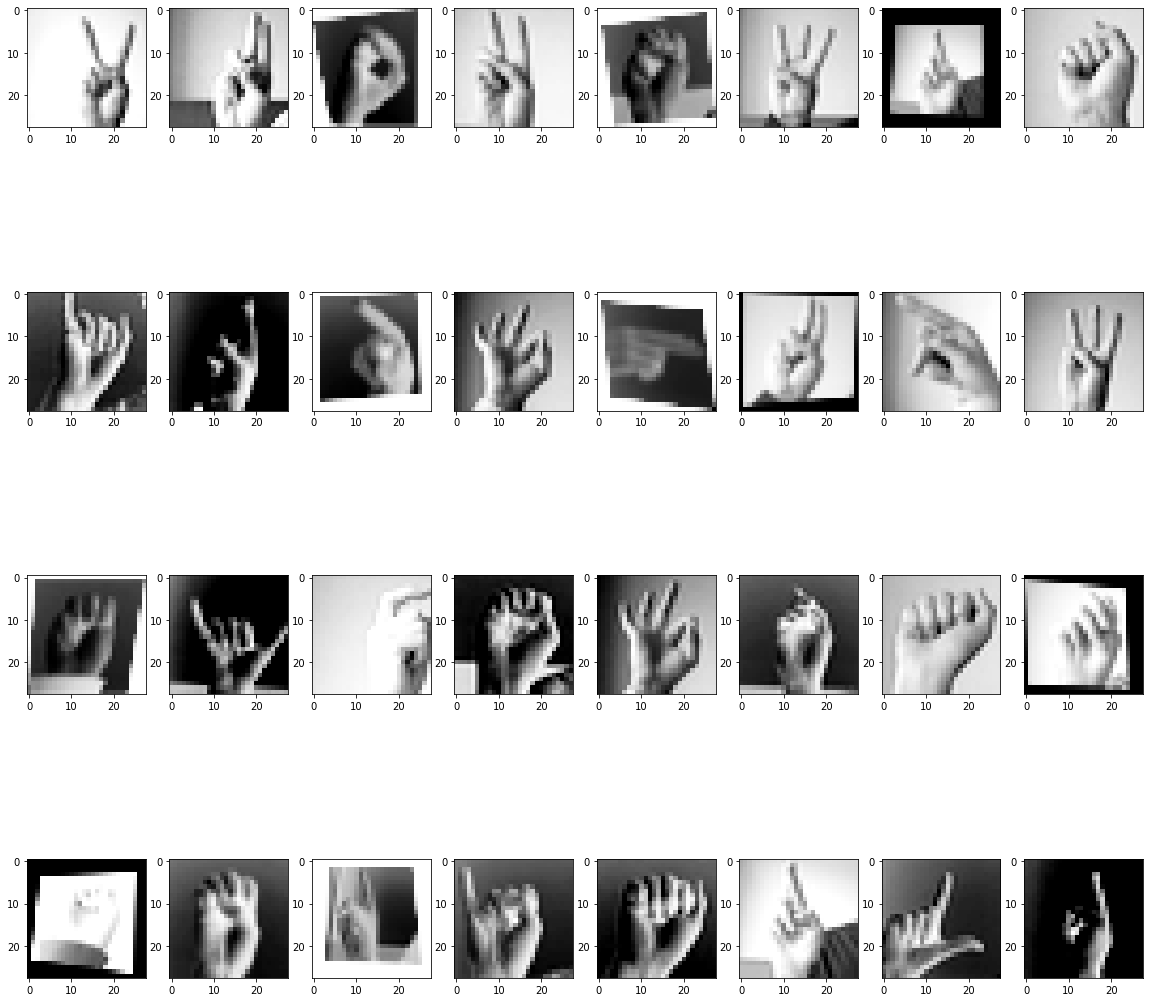

In [25]:
plt.figure(figsize=(20,20))

for i in range(32):
    sample = next(iter(trainloader))
    plt.subplot(4, 8, i+1)
    plt.imshow(torch.squeeze(sample[0][0]).to('cpu'), cmap='Greys')
plt.show()

Now that I have created my data loaders and passed the first set of transformations to augment the data, the next step is to create, train and evaluate the CNN model.

## Model development

In [164]:
import torch.nn as nn

In [165]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [166]:
model = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), 
                      nn.ReLU(),
                      nn.Conv2d(64, 128, 3, padding=1),
                      nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(128*28*28, 1024),
                      nn.Linear(1024, 512),
                      nn.Linear(512, 24))

In [167]:
CNN = model.to('cuda')

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(CNN.parameters(), lr=0.005)

In [168]:
epochs = 25
train_losses=[]
test_losses=[]
train_accuracies = []
test_accuracies = []
batch_num = 0
softmax = nn.Softmax(dim=1)

from time import perf_counter

start_time = perf_counter()

for epoch in range(epochs):
    train_loss=0.0
    test_loss=0.0
    train_accuracy = []
    test_accuracy = []
    batch_num = 1

    CNN.train()
    for image, label in trainloader:

        optimizer.zero_grad()
        predict = CNN(image.float())
        loss = loss_function(predict, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * image.size(0)
        
        probabilities = softmax(predict)
        predicted_labels = probabilities.argmax(dim=1)
        correct_labels = (predicted_labels == label)
        accuracy = correct_labels.sum().float() / float(label.size(0))
        train_accuracy.append(accuracy)
        
        end_time = perf_counter()
        
        print(f"Batch {batch_num}: average train loss:{train_loss / (batch_num + 1)}, elapsed time: {(end_time-start_time)/60}, accuracy: {accuracy}")
        batch_num += 1
        
    CNN.eval()
    
    test_batch_num = 1
    
    for image, label in testloader:

        predict = CNN(image.float())
        loss = loss_function(predict, label)
        test_loss += loss.item() * image.size(0)
        
        probabilities = softmax(predict)
        predicted_labels = probabilities.argmax(dim=1)
        correct_labels = (predicted_labels == label)
        accuracy = correct_labels.sum().float() / float(label.size(0))
        test_accuracy.append(accuracy)
        test_batch_num += 1
        
    train_loss = train_loss / len(trainloader.sampler) 
    test_loss = test_loss / len(testloader.sampler)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    train_accuracies.append(sum(train_accuracy) / batch_num)
    test_accuracies.append(sum(test_accuracy) / test_batch_num)
    
    end_time = perf_counter()
    elapsed_time = (end_time - start_time) / 60

    print('\n Epoch {}: Train Loss {:.4f} valid Losss {:.4f} elapsed time {:.4f} avg train accuracy: {:.4f} avg test accuracy: {:.4f} \n'.format(epoch, train_loss, test_loss, elapsed_time, (sum(train_accuracy) / batch_num), (sum(test_accuracy) / test_batch_num)))


end_time = perf_counter()
total_elapsed_time = end_time - start_time    

print(f"Total elapsed time: {(end_time - start_time)  / 60}") 

Batch 1: average train loss:101.59705352783203, elapsed time: 0.003309761666605482, accuracy: 0.0625
Batch 2: average train loss:136.12940979003906, elapsed time: 0.007187914999910087, accuracy: 0.0
Batch 3: average train loss:152.93920516967773, elapsed time: 0.01074510333322299, accuracy: 0.0625
Batch 4: average train loss:162.42242736816405, elapsed time: 0.014444441666516166, accuracy: 0.078125
Batch 5: average train loss:169.39219919840494, elapsed time: 0.018368068333317448, accuracy: 0.015625
Batch 6: average train loss:174.39872087751115, elapsed time: 0.022504121666618932, accuracy: 0.03125
Batch 7: average train loss:178.04096221923828, elapsed time: 0.026328336666483664, accuracy: 0.015625
Batch 8: average train loss:180.6655731201172, elapsed time: 0.029961439999897265, accuracy: 0.09375
Batch 9: average train loss:183.31187896728517, elapsed time: 0.03360580499987312, accuracy: 0.046875
Batch 10: average train loss:185.22514759410512, elapsed time: 0.03728484166664809, acc

Batch 82: average train loss:200.87026591473315, elapsed time: 0.32063373333318546, accuracy: 0.015625
Batch 83: average train loss:200.88769222441175, elapsed time: 0.32433846666657096, accuracy: 0.03125
Batch 84: average train loss:200.90286613913145, elapsed time: 0.3281458716664929, accuracy: 0.03125
Batch 85: average train loss:200.9407783330873, elapsed time: 0.3317651316666646, accuracy: 0.0625
Batch 86: average train loss:200.95796168535605, elapsed time: 0.33549056666646115, accuracy: 0.015625
Batch 87: average train loss:200.97860596396706, elapsed time: 0.3395048783332944, accuracy: 0.09375
Batch 88: average train loss:200.99618238813423, elapsed time: 0.34316316666663627, accuracy: 0.09375
Batch 89: average train loss:201.0359654744466, elapsed time: 0.3488376766666382, accuracy: 0.09375
Batch 90: average train loss:201.05977504855983, elapsed time: 0.35444223499992705, accuracy: 0.078125
Batch 91: average train loss:201.08180916827658, elapsed time: 0.35804165833324075, ac

Batch 163: average train loss:201.46369282792253, elapsed time: 0.6467406483333131, accuracy: 0.125
Batch 164: average train loss:201.46335005326705, elapsed time: 0.6504098099998373, accuracy: 0.015625
Batch 165: average train loss:201.47437479409828, elapsed time: 0.6540943483332133, accuracy: 0.0625
Batch 166: average train loss:201.46395837475438, elapsed time: 0.6577299899998859, accuracy: 0.109375
Batch 167: average train loss:201.46635700407484, elapsed time: 0.661417224999847, accuracy: 0.078125
Batch 168: average train loss:201.45995642306536, elapsed time: 0.6650257866664712, accuracy: 0.109375
Batch 169: average train loss:201.4518563663258, elapsed time: 0.6688546000000012, accuracy: 0.0625
Batch 170: average train loss:201.45131197031478, elapsed time: 0.6724468583333267, accuracy: 0.0625
Batch 171: average train loss:201.45457733509153, elapsed time: 0.6763009066666806, accuracy: 0.046875
Batch 172: average train loss:201.45945104698225, elapsed time: 0.6800850399997823, 

Batch 244: average train loss:201.08977922712054, elapsed time: 0.9692418733332792, accuracy: 0.09375
Batch 245: average train loss:201.07006687071265, elapsed time: 0.9728027083331351, accuracy: 0.125
Batch 246: average train loss:201.07060297298045, elapsed time: 0.9765070249998341, accuracy: 0.0625
Batch 247: average train loss:201.0545373732044, elapsed time: 0.9801722150000084, accuracy: 0.09375
Batch 248: average train loss:201.0603368674895, elapsed time: 0.9837361816666089, accuracy: 0.0625
Batch 249: average train loss:201.06639807128906, elapsed time: 0.9874065333332207, accuracy: 0.078125
Batch 250: average train loss:201.05124229643926, elapsed time: 0.9913058199999796, accuracy: 0.1875
Batch 251: average train loss:201.03503139435298, elapsed time: 0.994850401666675, accuracy: 0.125
Batch 252: average train loss:201.03583457253197, elapsed time: 0.9985518333332342, accuracy: 0.046875
Batch 253: average train loss:201.03091929278037, elapsed time: 1.0022289683331715, accura

Batch 325: average train loss:200.38253456536978, elapsed time: 1.279019418333337, accuracy: 0.125
Batch 326: average train loss:200.37072198616985, elapsed time: 1.2827277666666002, accuracy: 0.125
Batch 327: average train loss:200.3608705474109, elapsed time: 1.2864929399998801, accuracy: 0.234375
Batch 328: average train loss:200.34439898551778, elapsed time: 1.2900960149997749, accuracy: 0.171875
Batch 329: average train loss:200.3329345703125, elapsed time: 1.2938957916664853, accuracy: 0.203125
Batch 330: average train loss:200.3269351832456, elapsed time: 1.2975013399998716, accuracy: 0.203125
Batch 331: average train loss:200.31734719333878, elapsed time: 1.3011845666665371, accuracy: 0.125
Batch 332: average train loss:200.30655942808042, elapsed time: 1.3049857216666472, accuracy: 0.046875
Batch 333: average train loss:200.29926053349843, elapsed time: 1.3085498999998284, accuracy: 0.109375
Batch 334: average train loss:200.28645670876574, elapsed time: 1.3122227449998414, ac

Batch 406: average train loss:199.38711517858857, elapsed time: 1.6219343416664438, accuracy: 0.21875
Batch 407: average train loss:199.3841567693972, elapsed time: 1.6257831116665329, accuracy: 0.109375
Batch 408: average train loss:199.3740987987565, elapsed time: 1.629357711666671, accuracy: 0.15625
Batch 409: average train loss:199.37717873177877, elapsed time: 1.6329467349998594, accuracy: 0.078125
Batch 410: average train loss:199.36624995693384, elapsed time: 1.636621598333295, accuracy: 0.15625
Batch 411: average train loss:199.3640575964474, elapsed time: 1.6404280116665177, accuracy: 0.09375
Batch 412: average train loss:199.34654003078654, elapsed time: 1.643998858333119, accuracy: 0.234375
Batch 413: average train loss:199.32798254777845, elapsed time: 1.647721809999833, accuracy: 0.171875
Batch 414: average train loss:199.30811179287463, elapsed time: 1.6513206883331197, accuracy: 0.21875
Batch 415: average train loss:199.29657451923077, elapsed time: 1.6550500783332003, a

Batch 58: average train loss:188.82151044425316, elapsed time: 2.015861136666596, accuracy: 0.203125
Batch 59: average train loss:188.85163294474285, elapsed time: 2.019631606666614, accuracy: 0.171875
Batch 60: average train loss:188.9276080522381, elapsed time: 2.0232509449999876, accuracy: 0.21875
Batch 61: average train loss:188.89204948179184, elapsed time: 2.0269306849998734, accuracy: 0.171875
Batch 62: average train loss:188.9491460890997, elapsed time: 2.0306848366664783, accuracy: 0.1875
Batch 63: average train loss:189.03106927871704, elapsed time: 2.0343901349998004, accuracy: 0.125
Batch 64: average train loss:189.03623704176684, elapsed time: 2.038124536666631, accuracy: 0.234375
Batch 65: average train loss:189.12108658299303, elapsed time: 2.043909091666622, accuracy: 0.140625
Batch 66: average train loss:189.2682520168931, elapsed time: 2.0475433616666123, accuracy: 0.09375
Batch 67: average train loss:189.41474959429573, elapsed time: 2.0529436866665494, accuracy: 0.1

Batch 140: average train loss:189.26938753601507, elapsed time: 2.378199544999855, accuracy: 0.125
Batch 141: average train loss:189.23113465644943, elapsed time: 2.3819898133331057, accuracy: 0.28125
Batch 142: average train loss:189.2601410125519, elapsed time: 2.3855635683331156, accuracy: 0.140625
Batch 143: average train loss:189.24150138431125, elapsed time: 2.3891766783332664, accuracy: 0.171875
Batch 144: average train loss:189.28993035678207, elapsed time: 2.3930200749998525, accuracy: 0.15625
Batch 145: average train loss:189.23785943854344, elapsed time: 2.396594976666529, accuracy: 0.1875
Batch 146: average train loss:189.2100537358498, elapsed time: 2.4002615283333095, accuracy: 0.125
Batch 147: average train loss:189.20317067326727, elapsed time: 2.4039535999999013, accuracy: 0.171875
Batch 148: average train loss:189.20246180591968, elapsed time: 2.40775587166645, accuracy: 0.171875
Batch 149: average train loss:189.15900583902996, elapsed time: 2.4113792150000033, accur

Batch 221: average train loss:187.5307189666473, elapsed time: 2.683388683333275, accuracy: 0.234375
Batch 222: average train loss:187.4633044597814, elapsed time: 2.6872125416666677, accuracy: 0.34375
Batch 223: average train loss:187.41660969597953, elapsed time: 2.6908161016666177, accuracy: 0.296875
Batch 224: average train loss:187.40237684461806, elapsed time: 2.6946135316664974, accuracy: 0.203125
Batch 225: average train loss:187.39367338197422, elapsed time: 2.6982335699998656, accuracy: 0.234375
Batch 226: average train loss:187.34274379377322, elapsed time: 2.701794288333137, accuracy: 0.328125
Batch 227: average train loss:187.29760668570535, elapsed time: 2.7055417216666684, accuracy: 0.234375
Batch 228: average train loss:187.3045978129691, elapsed time: 2.7110109199997776, accuracy: 0.1875
Batch 229: average train loss:187.29955026377803, elapsed time: 2.715505441666513, accuracy: 0.15625
Batch 230: average train loss:187.29405958827957, elapsed time: 2.71923593333316, a

Batch 302: average train loss:185.62498771239427, elapsed time: 3.0349605449999215, accuracy: 0.25
Batch 303: average train loss:185.61284426638954, elapsed time: 3.0387362133333227, accuracy: 0.28125
Batch 304: average train loss:185.56143683761846, elapsed time: 3.0423744466665084, accuracy: 0.34375
Batch 305: average train loss:185.55812925450942, elapsed time: 3.046029446666459, accuracy: 0.15625
Batch 306: average train loss:185.53090411754695, elapsed time: 3.049896006666677, accuracy: 0.21875
Batch 307: average train loss:185.52993150190875, elapsed time: 3.0534845166665034, accuracy: 0.234375
Batch 308: average train loss:185.49325324493705, elapsed time: 3.05717462333317, accuracy: 0.296875
Batch 309: average train loss:185.42506531746156, elapsed time: 3.061005578333182, accuracy: 0.3125
Batch 310: average train loss:185.3836358367822, elapsed time: 3.0646923933333405, accuracy: 0.328125
Batch 311: average train loss:185.34760807722043, elapsed time: 3.068387753333324, accura

Batch 384: average train loss:183.266548018022, elapsed time: 3.3404499450000005, accuracy: 0.375
Batch 385: average train loss:183.24978645601422, elapsed time: 3.3442350399998153, accuracy: 0.3125
Batch 386: average train loss:183.2149569094951, elapsed time: 3.347911549999844, accuracy: 0.3125
Batch 387: average train loss:183.2298875002517, elapsed time: 3.3515664833331056, accuracy: 0.171875
Batch 388: average train loss:183.20315245797516, elapsed time: 3.3552060449997954, accuracy: 0.28125
Batch 389: average train loss:183.15460588504106, elapsed time: 3.359222289999889, accuracy: 0.328125
Batch 390: average train loss:183.13340661714753, elapsed time: 3.36292995833331, accuracy: 0.265625
Batch 391: average train loss:183.1239066610531, elapsed time: 3.3665722866666328, accuracy: 0.25
Batch 392: average train loss:183.09543017516003, elapsed time: 3.3701912133331158, accuracy: 0.3125
Batch 393: average train loss:183.08955030876973, elapsed time: 3.3738452916666573, accuracy: 0.

Batch 36: average train loss:162.3131111763619, elapsed time: 3.7407536233331484, accuracy: 0.34375
Batch 37: average train loss:162.5724166067023, elapsed time: 3.744510886666588, accuracy: 0.28125
Batch 38: average train loss:162.6354503142528, elapsed time: 3.748379258333201, accuracy: 0.3125
Batch 39: average train loss:162.7184688568115, elapsed time: 3.7520047516666333, accuracy: 0.28125
Batch 40: average train loss:162.78296940501144, elapsed time: 3.7557237966665222, accuracy: 0.34375
Batch 41: average train loss:163.10208820161364, elapsed time: 3.7610010849998314, accuracy: 0.21875
Batch 42: average train loss:163.19277954101562, elapsed time: 3.764611366666456, accuracy: 0.3125
Batch 43: average train loss:163.0584321455522, elapsed time: 3.768366773333158, accuracy: 0.34375
Batch 44: average train loss:162.7017825656467, elapsed time: 3.772069379999933, accuracy: 0.421875
Batch 45: average train loss:162.42724277662194, elapsed time: 3.7757969149999555, accuracy: 0.40625
Ba

Batch 118: average train loss:163.0530399354566, elapsed time: 4.056956266666627, accuracy: 0.375
Batch 119: average train loss:162.88948567708334, elapsed time: 4.060583928333169, accuracy: 0.421875
Batch 120: average train loss:162.8561700237684, elapsed time: 4.064443901666527, accuracy: 0.3125
Batch 121: average train loss:162.78580087130186, elapsed time: 4.0681478566664735, accuracy: 0.375
Batch 122: average train loss:162.79215482386147, elapsed time: 4.071996746666506, accuracy: 0.296875
Batch 123: average train loss:162.64646480929466, elapsed time: 4.0755370483331115, accuracy: 0.390625
Batch 124: average train loss:162.57178649902343, elapsed time: 4.079304111666473, accuracy: 0.359375
Batch 125: average train loss:162.60557907346694, elapsed time: 4.083164093333228, accuracy: 0.3125
Batch 126: average train loss:162.5817818228654, elapsed time: 4.086760394999874, accuracy: 0.3125
Batch 127: average train loss:162.5294975042343, elapsed time: 4.090392838333113, accuracy: 0.3

Batch 200: average train loss:159.33295641846917, elapsed time: 4.361117323333262, accuracy: 0.34375
Batch 201: average train loss:159.25219160023303, elapsed time: 4.364808348333221, accuracy: 0.421875
Batch 202: average train loss:159.20514509830568, elapsed time: 4.368465346666441, accuracy: 0.40625
Batch 203: average train loss:159.1502441705442, elapsed time: 4.37214957833324, accuracy: 0.4375
Batch 204: average train loss:159.15261156035632, elapsed time: 4.376057996666592, accuracy: 0.34375
Batch 205: average train loss:159.15914317010674, elapsed time: 4.379683521666448, accuracy: 0.34375
Batch 206: average train loss:159.11725730711711, elapsed time: 4.383346908333139, accuracy: 0.375
Batch 207: average train loss:159.00459597660944, elapsed time: 4.38713218833315, accuracy: 0.453125
Batch 208: average train loss:159.0088565954181, elapsed time: 4.390779208333212, accuracy: 0.34375
Batch 209: average train loss:158.91857786632718, elapsed time: 4.394484381666553, accuracy: 0.4

Batch 282: average train loss:155.5160101361494, elapsed time: 4.66504060833322, accuracy: 0.421875
Batch 283: average train loss:155.4676059131891, elapsed time: 4.668748859999808, accuracy: 0.453125
Batch 284: average train loss:155.3922462864926, elapsed time: 4.67235996833333, accuracy: 0.515625
Batch 285: average train loss:155.33141705706402, elapsed time: 4.6762344766665285, accuracy: 0.421875
Batch 286: average train loss:155.22602751196885, elapsed time: 4.679808566666664, accuracy: 0.484375
Batch 287: average train loss:155.18795784314474, elapsed time: 4.6834467749999025, accuracy: 0.453125
Batch 288: average train loss:155.1683236356425, elapsed time: 4.687165249999817, accuracy: 0.375
Batch 289: average train loss:155.06074581803946, elapsed time: 4.690906474999792, accuracy: 0.421875
Batch 290: average train loss:155.03212043264068, elapsed time: 4.694464599999871, accuracy: 0.453125
Batch 291: average train loss:154.97755369421554, elapsed time: 4.698137803333278, accura

Batch 363: average train loss:150.94020728226548, elapsed time: 4.962687354999798, accuracy: 0.578125
Batch 364: average train loss:150.8347778947386, elapsed time: 4.966367056666543, accuracy: 0.46875
Batch 365: average train loss:150.80939760885605, elapsed time: 4.97008669166656, accuracy: 0.359375
Batch 366: average train loss:150.74333230416195, elapsed time: 4.9737941099997744, accuracy: 0.390625
Batch 367: average train loss:150.674601306086, elapsed time: 4.977462183333167, accuracy: 0.46875
Batch 368: average train loss:150.62898593478732, elapsed time: 4.981160799999876, accuracy: 0.34375
Batch 369: average train loss:150.6139800612991, elapsed time: 4.984823286666506, accuracy: 0.375
Batch 370: average train loss:150.5884311809694, elapsed time: 4.9885365233332175, accuracy: 0.375
Batch 371: average train loss:150.52578386696436, elapsed time: 4.99222646499984, accuracy: 0.421875
Batch 372: average train loss:150.48005659906218, elapsed time: 4.99608310499995, accuracy: 0.48

Batch 15: average train loss:113.5783429145813, elapsed time: 5.324876754999908, accuracy: 0.453125
Batch 16: average train loss:113.4130630493164, elapsed time: 5.328579428333129, accuracy: 0.578125
Batch 17: average train loss:113.94005457560222, elapsed time: 5.332320113333116, accuracy: 0.453125
Batch 18: average train loss:113.99616643002159, elapsed time: 5.336185886666499, accuracy: 0.5625
Batch 19: average train loss:113.44362258911133, elapsed time: 5.339805041666598, accuracy: 0.65625
Batch 20: average train loss:113.81159173874627, elapsed time: 5.343549311666478, accuracy: 0.421875
Batch 21: average train loss:113.5906982421875, elapsed time: 5.347436429999894, accuracy: 0.515625
Batch 22: average train loss:113.58451445206352, elapsed time: 5.3511806599999545, accuracy: 0.484375
Batch 23: average train loss:114.02357133229573, elapsed time: 5.354804316666559, accuracy: 0.484375
Batch 24: average train loss:113.780732421875, elapsed time: 5.358473399999881, accuracy: 0.5468

Batch 98: average train loss:112.22727850711706, elapsed time: 5.630844694999784, accuracy: 0.453125
Batch 99: average train loss:112.15780738830567, elapsed time: 5.634661038333191, accuracy: 0.453125
Batch 100: average train loss:112.17502714855836, elapsed time: 5.638252478333258, accuracy: 0.40625
Batch 101: average train loss:112.03339797375249, elapsed time: 5.642030526666591, accuracy: 0.609375
Batch 102: average train loss:112.04377154007699, elapsed time: 5.645643131666535, accuracy: 0.5
Batch 103: average train loss:112.05149122384879, elapsed time: 5.649505701666445, accuracy: 0.578125
Batch 104: average train loss:112.03294031052363, elapsed time: 5.653061881666508, accuracy: 0.515625
Batch 105: average train loss:111.90544171603221, elapsed time: 5.656677893333108, accuracy: 0.609375
Batch 106: average train loss:111.9169539692246, elapsed time: 5.660376008333212, accuracy: 0.5625
Batch 107: average train loss:111.8622401908592, elapsed time: 5.664142591666557, accuracy: 0

Batch 180: average train loss:109.8007139764438, elapsed time: 5.932656704999924, accuracy: 0.53125
Batch 181: average train loss:109.73318535940987, elapsed time: 5.936398864999986, accuracy: 0.5625
Batch 182: average train loss:109.6814741124221, elapsed time: 5.940054421666476, accuracy: 0.515625
Batch 183: average train loss:109.68116241952647, elapsed time: 5.943760209999891, accuracy: 0.453125
Batch 184: average train loss:109.66162760966533, elapsed time: 5.9473792816665085, accuracy: 0.515625
Batch 185: average train loss:109.60492968815629, elapsed time: 5.951041749999907, accuracy: 0.515625
Batch 186: average train loss:109.55780943192262, elapsed time: 5.954739101666443, accuracy: 0.609375
Batch 187: average train loss:109.49469822011095, elapsed time: 5.958460259999993, accuracy: 0.546875
Batch 188: average train loss:109.36412823389448, elapsed time: 5.962125581666624, accuracy: 0.6875
Batch 189: average train loss:109.3188865661621, elapsed time: 5.965788709999955, accura

Batch 262: average train loss:105.84386911138382, elapsed time: 6.23467168833328, accuracy: 0.59375
Batch 263: average train loss:105.79142778570002, elapsed time: 6.238469061666547, accuracy: 0.578125
Batch 264: average train loss:105.74437877727004, elapsed time: 6.241999599999932, accuracy: 0.578125
Batch 265: average train loss:105.63005998080834, elapsed time: 6.245637846666553, accuracy: 0.65625
Batch 266: average train loss:105.58332156063466, elapsed time: 6.249404809999882, accuracy: 0.609375
Batch 267: average train loss:105.55533941468197, elapsed time: 6.252984091666439, accuracy: 0.578125
Batch 268: average train loss:105.51255730270896, elapsed time: 6.256632621666601, accuracy: 0.609375
Batch 269: average train loss:105.39969352439597, elapsed time: 6.260280298333237, accuracy: 0.6875
Batch 270: average train loss:105.33233524336586, elapsed time: 6.263951478333183, accuracy: 0.625
Batch 271: average train loss:105.26944101558013, elapsed time: 6.267607108333323, accurac

Batch 344: average train loss:101.74733446646428, elapsed time: 6.537383394999779, accuracy: 0.59375
Batch 345: average train loss:101.71889819988625, elapsed time: 6.540953476666618, accuracy: 0.640625
Batch 346: average train loss:101.68926564417242, elapsed time: 6.5446530933331815, accuracy: 0.5625
Batch 347: average train loss:101.64056777954102, elapsed time: 6.548304253333239, accuracy: 0.625
Batch 348: average train loss:101.5964094451642, elapsed time: 6.552035224999902, accuracy: 0.625
Batch 349: average train loss:101.52950605119977, elapsed time: 6.555763528333288, accuracy: 0.65625
Batch 350: average train loss:101.47734541499037, elapsed time: 6.559406778333263, accuracy: 0.625
Batch 351: average train loss:101.41120741584085, elapsed time: 6.563256958333174, accuracy: 0.625
Batch 352: average train loss:101.38134134524942, elapsed time: 6.566939475000011, accuracy: 0.5625
Batch 353: average train loss:101.33102826479464, elapsed time: 6.570612543333118, accuracy: 0.64062

Batch 426: average train loss:98.03443743417637, elapsed time: 6.839788533333194, accuracy: 0.546875
Batch 427: average train loss:98.00419601547384, elapsed time: 6.843392713333257, accuracy: 0.546875
Batch 428: average train loss:97.95279160968629, elapsed time: 6.847061046666446, accuracy: 0.65625
Batch 429: average train loss:97.9300902607829, elapsed time: 6.850798444999964, accuracy: 0.6349206566810608

 Epoch 3: Train Loss 1.5338 valid Losss 1.0996 elapsed time 6.9137 avg train accuracy: 0.5727 avg test accuracy: 0.6472 

Batch 1: average train loss:45.425865173339844, elapsed time: 6.9174306199999895, accuracy: 0.578125
Batch 2: average train loss:55.301859537760414, elapsed time: 6.921089076666491, accuracy: 0.640625
Batch 3: average train loss:61.29123306274414, elapsed time: 6.924873174999812, accuracy: 0.59375
Batch 4: average train loss:67.30923919677734, elapsed time: 6.92848407333319, accuracy: 0.578125
Batch 5: average train loss:70.27126820882161, elapsed time: 6.93216

Batch 79: average train loss:76.29136571884155, elapsed time: 7.204409201666567, accuracy: 0.625
Batch 80: average train loss:76.18801945815852, elapsed time: 7.208045741666623, accuracy: 0.765625
Batch 81: average train loss:76.16788771094346, elapsed time: 7.211688518333298, accuracy: 0.71875
Batch 82: average train loss:75.9575762461467, elapsed time: 7.2152655133332395, accuracy: 0.796875
Batch 83: average train loss:76.00206983657111, elapsed time: 7.218989333333108, accuracy: 0.640625
Batch 84: average train loss:75.82364569271311, elapsed time: 7.222582529999879, accuracy: 0.796875
Batch 85: average train loss:75.71961873076683, elapsed time: 7.226335276666457, accuracy: 0.71875
Batch 86: average train loss:75.65402813615471, elapsed time: 7.2300205333333, accuracy: 0.703125
Batch 87: average train loss:75.79051394896074, elapsed time: 7.233714108333273, accuracy: 0.703125
Batch 88: average train loss:75.83661621608091, elapsed time: 7.2373291183333395, accuracy: 0.65625
Batch 8

Batch 163: average train loss:73.20270554612323, elapsed time: 7.512802768333253, accuracy: 0.59375
Batch 164: average train loss:73.18401158650717, elapsed time: 7.516369528333113, accuracy: 0.671875
Batch 165: average train loss:73.10612988759236, elapsed time: 7.520045289999931, accuracy: 0.703125
Batch 166: average train loss:73.10160909869714, elapsed time: 7.523829486666606, accuracy: 0.703125
Batch 167: average train loss:73.03137459073749, elapsed time: 7.5275635066665325, accuracy: 0.75
Batch 168: average train loss:73.1459255105645, elapsed time: 7.531266523333276, accuracy: 0.515625
Batch 169: average train loss:73.08399209415211, elapsed time: 7.5350689133333315, accuracy: 0.703125
Batch 170: average train loss:73.07672846387004, elapsed time: 7.5388072049999515, accuracy: 0.71875
Batch 171: average train loss:73.01711601434752, elapsed time: 7.542414051666613, accuracy: 0.71875
Batch 172: average train loss:73.04788327079288, elapsed time: 7.546163281666668, accuracy: 0.68

Batch 245: average train loss:70.78738848368327, elapsed time: 7.814472643333284, accuracy: 0.765625
Batch 246: average train loss:70.73557542499744, elapsed time: 7.818135783333128, accuracy: 0.765625
Batch 247: average train loss:70.6486524305036, elapsed time: 7.821772025000003, accuracy: 0.8125
Batch 248: average train loss:70.57964000165701, elapsed time: 7.825406563333187, accuracy: 0.78125
Batch 249: average train loss:70.53443008422852, elapsed time: 7.82904317499997, accuracy: 0.734375
Batch 250: average train loss:70.48897449143854, elapsed time: 7.832755948333215, accuracy: 0.734375
Batch 251: average train loss:70.5083411988758, elapsed time: 7.836578658333262, accuracy: 0.5625
Batch 252: average train loss:70.51948553394423, elapsed time: 7.840154841666663, accuracy: 0.625
Batch 253: average train loss:70.52040118119848, elapsed time: 7.8438982949999625, accuracy: 0.65625
Batch 254: average train loss:70.50464354870365, elapsed time: 7.8474972966665515, accuracy: 0.640625


Batch 327: average train loss:68.55850424417635, elapsed time: 8.11718252999999, accuracy: 0.765625
Batch 328: average train loss:68.5694926299585, elapsed time: 8.120898323333192, accuracy: 0.609375
Batch 329: average train loss:68.56849862300989, elapsed time: 8.124584986666498, accuracy: 0.671875
Batch 330: average train loss:68.52131197603808, elapsed time: 8.128259003333126, accuracy: 0.78125
Batch 331: average train loss:68.53863257672413, elapsed time: 8.131995899999795, accuracy: 0.71875
Batch 332: average train loss:68.47637020718228, elapsed time: 8.135641208333254, accuracy: 0.8125
Batch 333: average train loss:68.45713477220364, elapsed time: 8.139308574999935, accuracy: 0.65625
Batch 334: average train loss:68.44152966399692, elapsed time: 8.14315089999994, accuracy: 0.78125
Batch 335: average train loss:68.38595721835182, elapsed time: 8.147105583333177, accuracy: 0.765625
Batch 336: average train loss:68.30551261788659, elapsed time: 8.150721154999822, accuracy: 0.78125


Batch 410: average train loss:66.9133913360373, elapsed time: 8.482783461666502, accuracy: 0.71875
Batch 411: average train loss:66.91362480978364, elapsed time: 8.48671147999994, accuracy: 0.75
Batch 412: average train loss:66.8889460251926, elapsed time: 8.491233071666647, accuracy: 0.734375
Batch 413: average train loss:66.84180773859438, elapsed time: 8.494790744999772, accuracy: 0.78125
Batch 414: average train loss:66.82952611532556, elapsed time: 8.498501738333289, accuracy: 0.71875
Batch 415: average train loss:66.78383652980511, elapsed time: 8.50224202499982, accuracy: 0.796875
Batch 416: average train loss:66.80400857536627, elapsed time: 8.505891313333269, accuracy: 0.6875
Batch 417: average train loss:66.7755261197615, elapsed time: 8.509534534999936, accuracy: 0.78125
Batch 418: average train loss:66.74934893405523, elapsed time: 8.51333436833326, accuracy: 0.75
Batch 419: average train loss:66.71107301257905, elapsed time: 8.516961851666565, accuracy: 0.78125
Batch 420: 

Batch 63: average train loss:56.12531119585037, elapsed time: 8.853769764999985, accuracy: 0.765625
Batch 64: average train loss:55.89277466994066, elapsed time: 8.857471949999793, accuracy: 0.8125
Batch 65: average train loss:55.56913890260638, elapsed time: 8.86143481333323, accuracy: 0.890625
Batch 66: average train loss:55.44769936177268, elapsed time: 8.865079244999894, accuracy: 0.859375
Batch 67: average train loss:55.347598524654614, elapsed time: 8.868782376666543, accuracy: 0.734375
Batch 68: average train loss:55.306552112966344, elapsed time: 8.872836928333223, accuracy: 0.8125
Batch 69: average train loss:55.246169553484236, elapsed time: 8.876394233333121, accuracy: 0.671875
Batch 70: average train loss:55.14822006225586, elapsed time: 8.880078054999952, accuracy: 0.8125
Batch 71: average train loss:55.0774499575297, elapsed time: 8.883849236666476, accuracy: 0.765625
Batch 72: average train loss:55.28308580999505, elapsed time: 8.887702778333187, accuracy: 0.609375
Batch

Batch 146: average train loss:54.83744025716976, elapsed time: 9.179009054999915, accuracy: 0.765625
Batch 147: average train loss:54.89785217594456, elapsed time: 9.182687374999903, accuracy: 0.703125
Batch 148: average train loss:54.8484364707998, elapsed time: 9.186255394999899, accuracy: 0.765625
Batch 149: average train loss:54.74861345926921, elapsed time: 9.189788554999783, accuracy: 0.84375
Batch 150: average train loss:54.579894867953875, elapsed time: 9.193312119999852, accuracy: 0.921875
Batch 151: average train loss:54.48017893339458, elapsed time: 9.1969626966665, accuracy: 0.796875
Batch 152: average train loss:54.45736971088484, elapsed time: 9.202280229999936, accuracy: 0.8125
Batch 153: average train loss:54.49428858075823, elapsed time: 9.207724264999948, accuracy: 0.6875
Batch 154: average train loss:54.40083642775013, elapsed time: 9.212253006666531, accuracy: 0.828125
Batch 155: average train loss:54.3098392975636, elapsed time: 9.215884649999984, accuracy: 0.79687

Batch 229: average train loss:53.40985976509426, elapsed time: 9.57738725333329, accuracy: 0.765625
Batch 230: average train loss:53.439562446627264, elapsed time: 9.581281458333251, accuracy: 0.78125
Batch 231: average train loss:53.4320519381556, elapsed time: 9.584895168333121, accuracy: 0.765625
Batch 232: average train loss:53.39942354194084, elapsed time: 9.58866331333314, accuracy: 0.78125
Batch 233: average train loss:53.3768985617874, elapsed time: 9.592311901666593, accuracy: 0.828125
Batch 234: average train loss:53.37839787260015, elapsed time: 9.596034304999922, accuracy: 0.78125
Batch 235: average train loss:53.389007002620374, elapsed time: 9.599892308333317, accuracy: 0.703125
Batch 236: average train loss:53.3412562181175, elapsed time: 9.603669136666577, accuracy: 0.78125
Batch 237: average train loss:53.29909529806185, elapsed time: 9.607418166666564, accuracy: 0.78125
Batch 238: average train loss:53.2421396965761, elapsed time: 9.611102371666494, accuracy: 0.78125


Batch 311: average train loss:52.13249265841949, elapsed time: 9.894281704999836, accuracy: 0.84375
Batch 312: average train loss:52.07942959599602, elapsed time: 9.898139168333243, accuracy: 0.84375
Batch 313: average train loss:52.004210617891545, elapsed time: 9.903820988333125, accuracy: 0.90625
Batch 314: average train loss:51.97879463680207, elapsed time: 9.909110293333166, accuracy: 0.75
Batch 315: average train loss:51.96343036241169, elapsed time: 9.912732699999955, accuracy: 0.734375
Batch 316: average train loss:51.93378805286877, elapsed time: 9.916746356666652, accuracy: 0.828125
Batch 317: average train loss:51.92577746529249, elapsed time: 9.920393118333111, accuracy: 0.78125
Batch 318: average train loss:51.92587497316558, elapsed time: 9.924163576666615, accuracy: 0.75
Batch 319: average train loss:51.92131287455559, elapsed time: 9.927754988333133, accuracy: 0.703125
Batch 320: average train loss:51.905039808089114, elapsed time: 9.931442379999984, accuracy: 0.765625


Batch 393: average train loss:50.93222473841633, elapsed time: 10.21631723499983, accuracy: 0.765625
Batch 394: average train loss:50.962658971472635, elapsed time: 10.22002952999998, accuracy: 0.6875
Batch 395: average train loss:50.957751572734175, elapsed time: 10.223979568333258, accuracy: 0.78125
Batch 396: average train loss:50.952848420035025, elapsed time: 10.228056799999953, accuracy: 0.828125
Batch 397: average train loss:50.9232742175385, elapsed time: 10.231867084999976, accuracy: 0.859375
Batch 398: average train loss:50.919894741890126, elapsed time: 10.23546577999999, accuracy: 0.75
Batch 399: average train loss:50.8859619808197, elapsed time: 10.239372869999837, accuracy: 0.84375
Batch 400: average train loss:50.88876257156791, elapsed time: 10.24293597666668, accuracy: 0.8125
Batch 401: average train loss:50.87840569908939, elapsed time: 10.24675531833321, accuracy: 0.765625
Batch 402: average train loss:50.839699094407905, elapsed time: 10.250303598333266, accuracy: 0

Batch 45: average train loss:41.837018842282504, elapsed time: 10.625169043333154, accuracy: 0.734375
Batch 46: average train loss:41.85189109152936, elapsed time: 10.628904961666558, accuracy: 0.8125
Batch 47: average train loss:41.895412723223366, elapsed time: 10.632727776666677, accuracy: 0.796875
Batch 48: average train loss:42.08488187984545, elapsed time: 10.636304744999991, accuracy: 0.78125
Batch 49: average train loss:42.49010944366455, elapsed time: 10.639966216666654, accuracy: 0.71875
Batch 50: average train loss:42.722123950135476, elapsed time: 10.64366638666664, accuracy: 0.78125
Batch 51: average train loss:42.81204293324397, elapsed time: 10.647259726666622, accuracy: 0.8125
Batch 52: average train loss:42.683454081697285, elapsed time: 10.650994898333254, accuracy: 0.84375
Batch 53: average train loss:42.73875805183693, elapsed time: 10.654635109999798, accuracy: 0.796875
Batch 54: average train loss:42.73131398287686, elapsed time: 10.658296889999958, accuracy: 0.81

Batch 127: average train loss:43.988586604595184, elapsed time: 10.953909799999868, accuracy: 0.65625
Batch 128: average train loss:44.064393124839135, elapsed time: 10.957608431666449, accuracy: 0.765625
Batch 129: average train loss:44.056890781109146, elapsed time: 10.961308524999913, accuracy: 0.8125
Batch 130: average train loss:44.03331491601376, elapsed time: 10.965013518333338, accuracy: 0.78125
Batch 131: average train loss:44.00153232343269, elapsed time: 10.96864560833322, accuracy: 0.859375
Batch 132: average train loss:43.92178482399847, elapsed time: 10.972576733333215, accuracy: 0.84375
Batch 133: average train loss:43.85649510283968, elapsed time: 10.976121448333288, accuracy: 0.828125
Batch 134: average train loss:43.93643151742441, elapsed time: 10.979800898333147, accuracy: 0.71875
Batch 135: average train loss:44.00469984727747, elapsed time: 10.983458831666455, accuracy: 0.75
Batch 136: average train loss:44.012627093461305, elapsed time: 10.987206991666607, accura

Batch 209: average train loss:43.43815623692104, elapsed time: 11.267408089999906, accuracy: 0.734375
Batch 210: average train loss:43.38386384683763, elapsed time: 11.27104052333331, accuracy: 0.90625
Batch 211: average train loss:43.31390525709908, elapsed time: 11.274788633333324, accuracy: 0.875
Batch 212: average train loss:43.27686944701862, elapsed time: 11.278678823333273, accuracy: 0.84375
Batch 213: average train loss:43.309464811164645, elapsed time: 11.282412404999922, accuracy: 0.734375
Batch 214: average train loss:43.325368047315024, elapsed time: 11.286173501666537, accuracy: 0.828125
Batch 215: average train loss:43.35575240629691, elapsed time: 11.290048643333284, accuracy: 0.703125
Batch 216: average train loss:43.41459167937529, elapsed time: 11.29421492499993, accuracy: 0.765625
Batch 217: average train loss:43.43860858077303, elapsed time: 11.298221924999961, accuracy: 0.796875
Batch 218: average train loss:43.46187423462193, elapsed time: 11.302238386666675, accu

Batch 290: average train loss:43.46064310630982, elapsed time: 11.57488507333328, accuracy: 0.78125
Batch 291: average train loss:43.420904786619424, elapsed time: 11.578461571666654, accuracy: 0.78125
Batch 292: average train loss:43.38762744213534, elapsed time: 11.582154221666618, accuracy: 0.875
Batch 293: average train loss:43.34652260371617, elapsed time: 11.585882774999966, accuracy: 0.875
Batch 294: average train loss:43.30692134145963, elapsed time: 11.589555051666443, accuracy: 0.84375
Batch 295: average train loss:43.31392928071924, elapsed time: 11.593354063333148, accuracy: 0.828125
Batch 296: average train loss:43.25435116315129, elapsed time: 11.596906278333336, accuracy: 0.921875
Batch 297: average train loss:43.22309626508879, elapsed time: 11.600970341666592, accuracy: 0.8125
Batch 298: average train loss:43.23041378136064, elapsed time: 11.604974769999778, accuracy: 0.828125
Batch 299: average train loss:43.24197371800741, elapsed time: 11.60870905833314, accuracy: 0

Batch 372: average train loss:42.21902356902012, elapsed time: 11.898628063333309, accuracy: 0.84375
Batch 373: average train loss:42.19719447681611, elapsed time: 11.902406171666614, accuracy: 0.828125
Batch 374: average train loss:42.227219568888344, elapsed time: 11.906204678333113, accuracy: 0.734375
Batch 375: average train loss:42.21482662951693, elapsed time: 11.909796666666564, accuracy: 0.859375
Batch 376: average train loss:42.19190933976313, elapsed time: 11.913662964999821, accuracy: 0.8125
Batch 377: average train loss:42.1538909881834, elapsed time: 11.91777967499996, accuracy: 0.875
Batch 378: average train loss:42.13589896753155, elapsed time: 11.921559248333264, accuracy: 0.796875
Batch 379: average train loss:42.101593158119606, elapsed time: 11.925522851666512, accuracy: 0.890625
Batch 380: average train loss:42.110217637590225, elapsed time: 11.929580523333183, accuracy: 0.828125
Batch 381: average train loss:42.11715341737757, elapsed time: 11.933411068333225, accu

Batch 24: average train loss:37.04211540222168, elapsed time: 12.30443641999979, accuracy: 0.8125
Batch 25: average train loss:36.79567080277663, elapsed time: 12.308225669999956, accuracy: 0.890625
Batch 26: average train loss:36.757707878395365, elapsed time: 12.311912998333234, accuracy: 0.828125
Batch 27: average train loss:36.314750467027935, elapsed time: 12.315527801666516, accuracy: 0.859375
Batch 28: average train loss:36.425351044227334, elapsed time: 12.319374036666462, accuracy: 0.796875
Batch 29: average train loss:36.57002201080322, elapsed time: 12.323161054999947, accuracy: 0.8125
Batch 30: average train loss:36.789106369018555, elapsed time: 12.326816616666473, accuracy: 0.84375
Batch 31: average train loss:36.829231560230255, elapsed time: 12.330522499999885, accuracy: 0.8125
Batch 32: average train loss:36.684204159360945, elapsed time: 12.334139473333199, accuracy: 0.84375
Batch 33: average train loss:36.68359313291662, elapsed time: 12.337882666666458, accuracy: 0.

Batch 106: average train loss:36.615842195314784, elapsed time: 12.65802092999996, accuracy: 0.890625
Batch 107: average train loss:36.69070363927771, elapsed time: 12.661873474999933, accuracy: 0.8125
Batch 108: average train loss:36.580347883591955, elapsed time: 12.6657221566665, accuracy: 0.921875
Batch 109: average train loss:36.575160633433946, elapsed time: 12.669549828333158, accuracy: 0.796875
Batch 110: average train loss:36.48784752579423, elapsed time: 12.673347246666527, accuracy: 0.859375
Batch 111: average train loss:36.54359788554056, elapsed time: 12.677075863333206, accuracy: 0.8125
Batch 112: average train loss:36.59452460297441, elapsed time: 12.680726711666647, accuracy: 0.796875
Batch 113: average train loss:36.66497412899084, elapsed time: 12.684392056666548, accuracy: 0.84375
Batch 114: average train loss:36.62360358860182, elapsed time: 12.688240271666533, accuracy: 0.859375
Batch 115: average train loss:36.55329286641088, elapsed time: 12.691818586666583, accu

Batch 187: average train loss:36.593234853541595, elapsed time: 12.980913681666667, accuracy: 0.828125
Batch 188: average train loss:36.58303271904194, elapsed time: 12.984660411666603, accuracy: 0.8125
Batch 189: average train loss:36.581641147011204, elapsed time: 12.988749176666655, accuracy: 0.875
Batch 190: average train loss:36.56991207662053, elapsed time: 12.992734493333167, accuracy: 0.78125
Batch 191: average train loss:36.53525911768278, elapsed time: 12.996671074999904, accuracy: 0.890625
Batch 192: average train loss:36.473231478676276, elapsed time: 13.000439236666473, accuracy: 0.875
Batch 193: average train loss:36.46330597474403, elapsed time: 13.004322953333274, accuracy: 0.828125
Batch 194: average train loss:36.50532858432867, elapsed time: 13.008104361666483, accuracy: 0.78125
Batch 195: average train loss:36.529842279395275, elapsed time: 13.011699144999875, accuracy: 0.796875
Batch 196: average train loss:36.45959936422745, elapsed time: 13.015633819999978, accur

Batch 269: average train loss:35.5725692042598, elapsed time: 13.290849204999782, accuracy: 0.921875
Batch 270: average train loss:35.55260856741029, elapsed time: 13.295178741666556, accuracy: 0.859375
Batch 271: average train loss:35.56257885343888, elapsed time: 13.29878345666657, accuracy: 0.84375
Batch 272: average train loss:35.548929270370536, elapsed time: 13.302724143333277, accuracy: 0.84375
Batch 273: average train loss:35.56058967896622, elapsed time: 13.306472448333322, accuracy: 0.859375
Batch 274: average train loss:35.543788687966085, elapsed time: 13.310292464999899, accuracy: 0.875
Batch 275: average train loss:35.54476182357125, elapsed time: 13.314076408333252, accuracy: 0.828125
Batch 276: average train loss:35.51771456584173, elapsed time: 13.31787190666655, accuracy: 0.875
Batch 277: average train loss:35.49597761442335, elapsed time: 13.321620389999831, accuracy: 0.84375
Batch 278: average train loss:35.5290465474556, elapsed time: 13.325330574999922, accuracy: 

Batch 350: average train loss:35.17781553241262, elapsed time: 13.602487886666495, accuracy: 0.828125
Batch 351: average train loss:35.159628532149576, elapsed time: 13.6088076, accuracy: 0.859375
Batch 352: average train loss:35.164765041880834, elapsed time: 13.612975964999835, accuracy: 0.84375
Batch 353: average train loss:35.189771124198614, elapsed time: 13.616665508333245, accuracy: 0.828125
Batch 354: average train loss:35.18379800286092, elapsed time: 13.623019519999797, accuracy: 0.875
Batch 355: average train loss:35.2005620377787, elapsed time: 13.62690245166644, accuracy: 0.828125
Batch 356: average train loss:35.19969754259125, elapsed time: 13.630532804999772, accuracy: 0.8125
Batch 357: average train loss:35.181118586875876, elapsed time: 13.634390608333343, accuracy: 0.859375
Batch 358: average train loss:35.1579171236511, elapsed time: 13.640952189999856, accuracy: 0.890625
Batch 359: average train loss:35.14645292494032, elapsed time: 13.646766770000006, accuracy: 0.

Batch 1: average train loss:16.37920570373535, elapsed time: 14.03074160833324, accuracy: 0.8125
Batch 2: average train loss:19.049688975016277, elapsed time: 14.035104466666477, accuracy: 0.890625
Batch 3: average train loss:23.194315910339355, elapsed time: 14.038770024999879, accuracy: 0.796875
Batch 4: average train loss:23.338230514526366, elapsed time: 14.042428688333166, accuracy: 0.890625
Batch 5: average train loss:25.673022905985516, elapsed time: 14.047940333333342, accuracy: 0.8125
Batch 6: average train loss:26.303522654942103, elapsed time: 14.051934336666454, accuracy: 0.859375
Batch 7: average train loss:25.740225553512573, elapsed time: 14.055520233333178, accuracy: 0.890625
Batch 8: average train loss:27.3091983795166, elapsed time: 14.059207841666648, accuracy: 0.796875
Batch 9: average train loss:27.85035457611084, elapsed time: 14.06350710166662, accuracy: 0.859375
Batch 10: average train loss:27.88961271806197, elapsed time: 14.067605455000011, accuracy: 0.84375
B

Batch 83: average train loss:32.66328429040455, elapsed time: 14.366825769999801, accuracy: 0.8125
Batch 84: average train loss:32.570581222982966, elapsed time: 14.37058090666663, accuracy: 0.859375
Batch 85: average train loss:32.58458615458289, elapsed time: 14.37438506999994, accuracy: 0.875
Batch 86: average train loss:32.41508877414397, elapsed time: 14.378147588333134, accuracy: 0.953125
Batch 87: average train loss:32.45696994391355, elapsed time: 14.381868478333248, accuracy: 0.859375
Batch 88: average train loss:32.36408817634154, elapsed time: 14.387846531666582, accuracy: 0.890625
Batch 89: average train loss:32.325807899898955, elapsed time: 14.392232413333113, accuracy: 0.921875
Batch 90: average train loss:32.35731027414511, elapsed time: 14.398002934999871, accuracy: 0.828125
Batch 91: average train loss:32.30075144767761, elapsed time: 14.403044363333175, accuracy: 0.921875
Batch 92: average train loss:32.38832216365363, elapsed time: 14.40830842999979, accuracy: 0.796

Batch 164: average train loss:31.496652302597507, elapsed time: 14.708372893333339, accuracy: 0.859375
Batch 165: average train loss:31.599508526813555, elapsed time: 14.712240541666445, accuracy: 0.859375
Batch 166: average train loss:31.626496537716804, elapsed time: 14.715834321666625, accuracy: 0.8125
Batch 167: average train loss:31.650023221969604, elapsed time: 14.71944425666661, accuracy: 0.859375
Batch 168: average train loss:31.65391873466898, elapsed time: 14.723144346666475, accuracy: 0.828125
Batch 169: average train loss:31.64881810580983, elapsed time: 14.726735219999926, accuracy: 0.890625
Batch 170: average train loss:31.645624049225745, elapsed time: 14.73039823166667, accuracy: 0.875
Batch 171: average train loss:31.617706243381942, elapsed time: 14.734034158333332, accuracy: 0.921875
Batch 172: average train loss:31.54703992501849, elapsed time: 14.737801859999793, accuracy: 0.921875
Batch 173: average train loss:31.53015498457284, elapsed time: 14.741346043333275, 

Batch 245: average train loss:30.771889240761112, elapsed time: 15.0060299983333, accuracy: 0.8125
Batch 246: average train loss:30.733193173582254, elapsed time: 15.009725681666653, accuracy: 0.890625
Batch 247: average train loss:30.70658028894855, elapsed time: 15.01338501499995, accuracy: 0.921875
Batch 248: average train loss:30.673350449068, elapsed time: 15.01701216333313, accuracy: 0.90625
Batch 249: average train loss:30.69040260696411, elapsed time: 15.020856639999936, accuracy: 0.890625
Batch 250: average train loss:30.68085756719825, elapsed time: 15.024453709999943, accuracy: 0.875
Batch 251: average train loss:30.64526587062412, elapsed time: 15.028167436666505, accuracy: 0.921875
Batch 252: average train loss:30.584330193138875, elapsed time: 15.032025518333345, accuracy: 0.9375
Batch 253: average train loss:30.609846843509224, elapsed time: 15.035675973333127, accuracy: 0.84375
Batch 254: average train loss:30.59511520535338, elapsed time: 15.03939731833331, accuracy: 0

Batch 326: average train loss:30.141864321647436, elapsed time: 15.304202596666679, accuracy: 0.8125
Batch 327: average train loss:30.117967448583464, elapsed time: 15.307958125000004, accuracy: 0.90625
Batch 328: average train loss:30.134792878635025, elapsed time: 15.311660838333289, accuracy: 0.859375
Batch 329: average train loss:30.113921853267787, elapsed time: 15.315326106666665, accuracy: 0.90625
Batch 330: average train loss:30.103469410691737, elapsed time: 15.319035898333338, accuracy: 0.859375
Batch 331: average train loss:30.077905499791523, elapsed time: 15.322677831666564, accuracy: 0.921875
Batch 332: average train loss:30.082839106654262, elapsed time: 15.326325590000003, accuracy: 0.875
Batch 333: average train loss:30.051235324608353, elapsed time: 15.32996592499985, accuracy: 0.9375
Batch 334: average train loss:30.06364418143657, elapsed time: 15.333701246666655, accuracy: 0.828125
Batch 335: average train loss:30.059701698166982, elapsed time: 15.337365214999833, 

Batch 407: average train loss:29.510688332950366, elapsed time: 15.60236533833328, accuracy: 0.875
Batch 408: average train loss:29.528762836036588, elapsed time: 15.605980681666551, accuracy: 0.78125
Batch 409: average train loss:29.516974114208686, elapsed time: 15.60959693499996, accuracy: 0.921875
Batch 410: average train loss:29.49837502713911, elapsed time: 15.613242906666468, accuracy: 0.921875
Batch 411: average train loss:29.499915289647372, elapsed time: 15.61688883, accuracy: 0.828125
Batch 412: average train loss:29.486768842609397, elapsed time: 15.62053387333314, accuracy: 0.890625
Batch 413: average train loss:29.482609868625513, elapsed time: 15.624215701666495, accuracy: 0.859375
Batch 414: average train loss:29.482116258000755, elapsed time: 15.627910443333288, accuracy: 0.875
Batch 415: average train loss:29.48501718044281, elapsed time: 15.631585963333297, accuracy: 0.875
Batch 416: average train loss:29.493035350772118, elapsed time: 15.635237176666609, accuracy: 0

Batch 59: average train loss:27.55485871632894, elapsed time: 15.963144346666619, accuracy: 0.890625
Batch 60: average train loss:27.562652494086596, elapsed time: 15.966779343333231, accuracy: 0.875
Batch 61: average train loss:27.450767209452966, elapsed time: 15.970621738333284, accuracy: 0.921875
Batch 62: average train loss:27.456865795074947, elapsed time: 15.974187028333109, accuracy: 0.84375
Batch 63: average train loss:27.487664192914963, elapsed time: 15.977894774999974, accuracy: 0.890625
Batch 64: average train loss:27.46352521456205, elapsed time: 15.981547276666484, accuracy: 0.875
Batch 65: average train loss:27.375653382503625, elapsed time: 15.985171441666656, accuracy: 0.90625
Batch 66: average train loss:27.3174720023995, elapsed time: 15.988839069999813, accuracy: 0.875
Batch 67: average train loss:27.425155331106748, elapsed time: 15.992540239999895, accuracy: 0.8125
Batch 68: average train loss:27.33859822370004, elapsed time: 15.996142104999793, accuracy: 0.89062

Batch 141: average train loss:27.015279393800547, elapsed time: 16.26474137666664, accuracy: 0.921875
Batch 142: average train loss:26.9345439564098, elapsed time: 16.26855834499996, accuracy: 0.9375
Batch 143: average train loss:26.875114070044624, elapsed time: 16.2721068283332, accuracy: 0.921875
Batch 144: average train loss:26.795098751988903, elapsed time: 16.275787253333206, accuracy: 0.921875
Batch 145: average train loss:26.749796103124748, elapsed time: 16.279426609999792, accuracy: 0.90625
Batch 146: average train loss:26.741313447757644, elapsed time: 16.28313684166666, accuracy: 0.84375
Batch 147: average train loss:26.75336120579694, elapsed time: 16.28681001999988, accuracy: 0.890625
Batch 148: average train loss:26.729930167230183, elapsed time: 16.290473828333294, accuracy: 0.890625
Batch 149: average train loss:26.6729318300883, elapsed time: 16.294083249999918, accuracy: 0.9375
Batch 150: average train loss:26.780169537525303, elapsed time: 16.297773851666474, accura

Batch 222: average train loss:26.76182033983581, elapsed time: 16.563325776666655, accuracy: 0.90625
Batch 223: average train loss:26.774411103555135, elapsed time: 16.56696504499996, accuracy: 0.890625
Batch 224: average train loss:26.814414304097493, elapsed time: 16.570812951666447, accuracy: 0.796875
Batch 225: average train loss:26.776097673230467, elapsed time: 16.57434436499995, accuracy: 0.953125
Batch 226: average train loss:26.785596028298535, elapsed time: 16.57801884333312, accuracy: 0.828125
Batch 227: average train loss:26.78839603641577, elapsed time: 16.581867361666568, accuracy: 0.875
Batch 228: average train loss:26.79172928572742, elapsed time: 16.5854368883333, accuracy: 0.875
Batch 229: average train loss:26.785941766655963, elapsed time: 16.589416406666473, accuracy: 0.859375
Batch 230: average train loss:26.756604244182636, elapsed time: 16.59318061833328, accuracy: 0.921875
Batch 231: average train loss:26.7856383611416, elapsed time: 16.59689635166651, accuracy

Batch 303: average train loss:26.65036585142738, elapsed time: 16.860968776666656, accuracy: 0.875
Batch 304: average train loss:26.747937233721622, elapsed time: 16.864656021666452, accuracy: 0.8125
Batch 305: average train loss:26.758009215585545, elapsed time: 16.868334301666618, accuracy: 0.875
Batch 306: average train loss:26.75294586889907, elapsed time: 16.871994144999917, accuracy: 0.875
Batch 307: average train loss:26.756686003177197, elapsed time: 16.87562515999986, accuracy: 0.84375
Batch 308: average train loss:26.742790021556868, elapsed time: 16.87928360166649, accuracy: 0.890625
Batch 309: average train loss:26.716014791304065, elapsed time: 16.882974636666525, accuracy: 0.90625
Batch 310: average train loss:26.759094965036276, elapsed time: 16.886663904999782, accuracy: 0.828125
Batch 311: average train loss:26.795539321043552, elapsed time: 16.890310964999905, accuracy: 0.828125
Batch 312: average train loss:26.745966646237115, elapsed time: 16.89408223499995, accurac

Batch 384: average train loss:26.48143034105177, elapsed time: 17.159198128333326, accuracy: 0.875
Batch 385: average train loss:26.48161111347416, elapsed time: 17.162912008333176, accuracy: 0.84375
Batch 386: average train loss:26.486771655021094, elapsed time: 17.16667551999999, accuracy: 0.875
Batch 387: average train loss:26.486621773120053, elapsed time: 17.170328840000003, accuracy: 0.875
Batch 388: average train loss:26.477497630376742, elapsed time: 17.173900001666578, accuracy: 0.890625
Batch 389: average train loss:26.471573937244905, elapsed time: 17.177584936666488, accuracy: 0.875
Batch 390: average train loss:26.437933565710512, elapsed time: 17.181188516666587, accuracy: 0.9375
Batch 391: average train loss:26.446518642561777, elapsed time: 17.18497295499983, accuracy: 0.84375
Batch 392: average train loss:26.441419550480735, elapsed time: 17.188527603333206, accuracy: 0.84375
Batch 393: average train loss:26.429797233058718, elapsed time: 17.19222853499984, accuracy: 0

Batch 36: average train loss:22.98313264589052, elapsed time: 17.51912240666667, accuracy: 0.9375
Batch 37: average train loss:23.09632376620644, elapsed time: 17.52278331999987, accuracy: 0.84375
Batch 38: average train loss:23.050314927712463, elapsed time: 17.526390251666452, accuracy: 0.90625
Batch 39: average train loss:23.209944200515746, elapsed time: 17.530188936666672, accuracy: 0.875
Batch 40: average train loss:23.18790482311714, elapsed time: 17.533776260000014, accuracy: 0.90625
Batch 41: average train loss:23.001940863473074, elapsed time: 17.537437471666635, accuracy: 0.953125
Batch 42: average train loss:23.045221994089527, elapsed time: 17.54117791999985, accuracy: 0.90625
Batch 43: average train loss:23.28932476043701, elapsed time: 17.544843533333186, accuracy: 0.890625
Batch 44: average train loss:23.53049528333876, elapsed time: 17.548541334999996, accuracy: 0.859375
Batch 45: average train loss:23.668770707171895, elapsed time: 17.552209351666534, accuracy: 0.8593

Batch 118: average train loss:23.10687889772303, elapsed time: 17.82034086499989, accuracy: 0.890625
Batch 119: average train loss:23.088901750246684, elapsed time: 17.824071203333247, accuracy: 0.9375
Batch 120: average train loss:23.110081152482465, elapsed time: 17.827718134999788, accuracy: 0.875
Batch 121: average train loss:23.064302577347053, elapsed time: 17.8314548099998, accuracy: 0.90625
Batch 122: average train loss:23.121818705302914, elapsed time: 17.835080661666627, accuracy: 0.890625
Batch 123: average train loss:23.259900162296912, elapsed time: 17.83879180833319, accuracy: 0.890625
Batch 124: average train loss:23.273977745056154, elapsed time: 17.84246934499994, accuracy: 0.890625
Batch 125: average train loss:23.411188814375137, elapsed time: 17.846146398333318, accuracy: 0.828125
Batch 126: average train loss:23.40888907214788, elapsed time: 17.849796421666543, accuracy: 0.890625
Batch 127: average train loss:23.469244621694088, elapsed time: 17.853635598333252, ac

Batch 199: average train loss:23.92176009654999, elapsed time: 18.117902531666672, accuracy: 0.890625
Batch 200: average train loss:23.93729191395774, elapsed time: 18.12158792500001, accuracy: 0.859375
Batch 201: average train loss:23.958751796495797, elapsed time: 18.125266163333194, accuracy: 0.921875
Batch 202: average train loss:23.99964557610122, elapsed time: 18.12889470333321, accuracy: 0.828125
Batch 203: average train loss:23.998961004556396, elapsed time: 18.13253947999983, accuracy: 0.921875
Batch 204: average train loss:24.023447543818776, elapsed time: 18.136217119999976, accuracy: 0.828125
Batch 205: average train loss:23.984598729216938, elapsed time: 18.13993673499984, accuracy: 0.921875
Batch 206: average train loss:23.922644863957945, elapsed time: 18.14362019499992, accuracy: 0.953125
Batch 207: average train loss:23.901576780355892, elapsed time: 18.14723226666659, accuracy: 0.921875
Batch 208: average train loss:23.899337262057802, elapsed time: 18.150879288333332

Batch 280: average train loss:23.698938342600105, elapsed time: 18.415925024999886, accuracy: 0.953125
Batch 281: average train loss:23.725497962735222, elapsed time: 18.419551134999832, accuracy: 0.84375
Batch 282: average train loss:23.710460548266084, elapsed time: 18.423241131666632, accuracy: 0.90625
Batch 283: average train loss:23.73061251304519, elapsed time: 18.42708299166649, accuracy: 0.859375
Batch 284: average train loss:23.741176417835973, elapsed time: 18.430670693333134, accuracy: 0.875
Batch 285: average train loss:23.709835689384622, elapsed time: 18.434296558333152, accuracy: 0.921875
Batch 286: average train loss:23.751379056259314, elapsed time: 18.437985836666485, accuracy: 0.84375
Batch 287: average train loss:23.785205493370693, elapsed time: 18.441683741666445, accuracy: 0.859375
Batch 288: average train loss:23.756029723012322, elapsed time: 18.445352619999902, accuracy: 0.96875
Batch 289: average train loss:23.740429029793575, elapsed time: 18.449015999999876

Batch 361: average train loss:23.43801991057001, elapsed time: 18.715425183333235, accuracy: 0.9375
Batch 362: average train loss:23.442008099936913, elapsed time: 18.719040118333215, accuracy: 0.875
Batch 363: average train loss:23.436206068311417, elapsed time: 18.72269147666666, accuracy: 0.875
Batch 364: average train loss:23.450361753489872, elapsed time: 18.72634675833324, accuracy: 0.8125
Batch 365: average train loss:23.4867146236649, elapsed time: 18.730104269999963, accuracy: 0.828125
Batch 366: average train loss:23.484222900640088, elapsed time: 18.733714813333304, accuracy: 0.890625
Batch 367: average train loss:23.52315580326578, elapsed time: 18.737366976666575, accuracy: 0.859375
Batch 368: average train loss:23.506485254137818, elapsed time: 18.74108695833323, accuracy: 0.921875
Batch 369: average train loss:23.499430506938214, elapsed time: 18.744746491666593, accuracy: 0.9375
Batch 370: average train loss:23.49457319727484, elapsed time: 18.748631811666563, accuracy:

Batch 12: average train loss:20.229802571810207, elapsed time: 19.07220414166659, accuracy: 0.90625
Batch 13: average train loss:20.150351864951, elapsed time: 19.07588833666644, accuracy: 0.9375
Batch 14: average train loss:20.93408120473226, elapsed time: 19.079562778333152, accuracy: 0.890625
Batch 15: average train loss:20.61143010854721, elapsed time: 19.08315531333331, accuracy: 0.953125
Batch 16: average train loss:20.185777944677017, elapsed time: 19.086793983333337, accuracy: 0.9375
Batch 17: average train loss:20.002391868167454, elapsed time: 19.090493511666622, accuracy: 0.890625
Batch 18: average train loss:19.879656892073783, elapsed time: 19.09417877333326, accuracy: 0.921875
Batch 19: average train loss:19.818007898330688, elapsed time: 19.097872799999944, accuracy: 0.921875
Batch 20: average train loss:20.01121798015776, elapsed time: 19.101490931666678, accuracy: 0.890625
Batch 21: average train loss:20.30876805565574, elapsed time: 19.10518909166664, accuracy: 0.8906

Batch 94: average train loss:21.99659280275044, elapsed time: 19.37319330333315, accuracy: 0.921875
Batch 95: average train loss:22.003086179494858, elapsed time: 19.376869119999903, accuracy: 0.875
Batch 96: average train loss:21.95475858511384, elapsed time: 19.380530933333162, accuracy: 0.921875
Batch 97: average train loss:21.849288697145422, elapsed time: 19.384341228333263, accuracy: 0.953125
Batch 98: average train loss:21.819670291862103, elapsed time: 19.388208348333137, accuracy: 0.921875
Batch 99: average train loss:21.758648624420164, elapsed time: 19.391738344999855, accuracy: 0.96875
Batch 100: average train loss:21.683667249018605, elapsed time: 19.395370623333292, accuracy: 0.953125
Batch 101: average train loss:21.74857395770503, elapsed time: 19.399026949999826, accuracy: 0.859375
Batch 102: average train loss:21.717686810539764, elapsed time: 19.40266611666666, accuracy: 0.90625
Batch 103: average train loss:21.729640080378605, elapsed time: 19.406441259999944, accur

Batch 175: average train loss:21.26936514269222, elapsed time: 19.67189611833334, accuracy: 0.953125
Batch 176: average train loss:21.294538384777006, elapsed time: 19.675761844999943, accuracy: 0.859375
Batch 177: average train loss:21.241617561726088, elapsed time: 19.679433506666587, accuracy: 0.9375
Batch 178: average train loss:21.21785068511963, elapsed time: 19.682969448333218, accuracy: 0.921875
Batch 179: average train loss:21.206377002927994, elapsed time: 19.686694684999868, accuracy: 0.921875
Batch 180: average train loss:21.165996825497455, elapsed time: 19.69034217166651, accuracy: 0.9375
Batch 181: average train loss:21.13116327746884, elapsed time: 19.694156416666615, accuracy: 0.921875
Batch 182: average train loss:21.225040086631566, elapsed time: 19.69771822999998, accuracy: 0.828125
Batch 183: average train loss:21.23056808243627, elapsed time: 19.701429236666446, accuracy: 0.875
Batch 184: average train loss:21.202808488381876, elapsed time: 19.70508409833322, accu

Batch 256: average train loss:21.157968795716993, elapsed time: 19.9700926716665, accuracy: 0.90625
Batch 257: average train loss:21.191838611928066, elapsed time: 19.973815014999854, accuracy: 0.875
Batch 258: average train loss:21.190324967432208, elapsed time: 19.977479523333265, accuracy: 0.921875
Batch 259: average train loss:21.15805896612314, elapsed time: 19.98116976499999, accuracy: 0.90625
Batch 260: average train loss:21.197571721570245, elapsed time: 19.984794726666586, accuracy: 0.84375
Batch 261: average train loss:21.18545357507604, elapsed time: 19.98859825499991, accuracy: 0.9375
Batch 262: average train loss:21.182106496716635, elapsed time: 19.992189069999828, accuracy: 0.875
Batch 263: average train loss:21.17434879505273, elapsed time: 19.99586767666648, accuracy: 0.921875
Batch 264: average train loss:21.161072756209464, elapsed time: 19.999756031666525, accuracy: 0.9375
Batch 265: average train loss:21.16716433646984, elapsed time: 20.003401934999903, accuracy: 0

Batch 337: average train loss:21.02236067049602, elapsed time: 20.268129084999963, accuracy: 0.890625
Batch 338: average train loss:21.030788487741027, elapsed time: 20.27186835166649, accuracy: 0.859375
Batch 339: average train loss:21.01897874018725, elapsed time: 20.27543135333326, accuracy: 0.921875
Batch 340: average train loss:21.020615892326376, elapsed time: 20.27908293999984, accuracy: 0.90625
Batch 341: average train loss:21.012687419590197, elapsed time: 20.282623131666575, accuracy: 0.953125
Batch 342: average train loss:21.02911399057238, elapsed time: 20.28629975833319, accuracy: 0.84375
Batch 343: average train loss:21.01148092608119, elapsed time: 20.28998359833325, accuracy: 0.953125
Batch 344: average train loss:20.998624178292093, elapsed time: 20.29357590833315, accuracy: 0.9375
Batch 345: average train loss:20.994639039728682, elapsed time: 20.297259909999898, accuracy: 0.90625
Batch 346: average train loss:20.99844755150743, elapsed time: 20.300843048333142, accur

Batch 418: average train loss:21.018324099747833, elapsed time: 20.566772323333133, accuracy: 0.921875
Batch 419: average train loss:21.005504377683003, elapsed time: 20.57045746166647, accuracy: 0.9375
Batch 420: average train loss:20.996367611964356, elapsed time: 20.574137446666523, accuracy: 0.90625
Batch 421: average train loss:20.988441771240595, elapsed time: 20.57780200666651, accuracy: 0.921875
Batch 422: average train loss:20.980794452324545, elapsed time: 20.581498044999897, accuracy: 0.921875
Batch 423: average train loss:20.96673328359172, elapsed time: 20.58516128333334, accuracy: 0.953125
Batch 424: average train loss:20.954731892978444, elapsed time: 20.588750789999903, accuracy: 0.9375
Batch 425: average train loss:20.94409106594856, elapsed time: 20.592380684999807, accuracy: 0.890625
Batch 426: average train loss:20.92616371695275, elapsed time: 20.596058569999876, accuracy: 0.953125
Batch 427: average train loss:20.922120469752873, elapsed time: 20.599931921666574, 

Batch 70: average train loss:19.590326188315807, elapsed time: 20.928485508333203, accuracy: 0.9375
Batch 71: average train loss:19.63419547345903, elapsed time: 20.932111409999926, accuracy: 0.90625
Batch 72: average train loss:19.68864925593546, elapsed time: 20.935770101666517, accuracy: 0.90625
Batch 73: average train loss:19.685751051516146, elapsed time: 20.939420789999954, accuracy: 0.9375
Batch 74: average train loss:19.86420591990153, elapsed time: 20.94327781999988, accuracy: 0.859375
Batch 75: average train loss:20.163659685536434, elapsed time: 20.946877154999918, accuracy: 0.84375
Batch 76: average train loss:20.16846836387337, elapsed time: 20.950642048333247, accuracy: 0.90625
Batch 77: average train loss:20.21310350222465, elapsed time: 20.954451566666588, accuracy: 0.890625
Batch 78: average train loss:20.150864407986024, elapsed time: 20.958042321666532, accuracy: 0.921875
Batch 79: average train loss:20.219195353984833, elapsed time: 20.96175539499988, accuracy: 0.89

Batch 153: average train loss:19.470527871862636, elapsed time: 21.234151613333232, accuracy: 0.8125
Batch 154: average train loss:19.47139047191989, elapsed time: 21.237739759999872, accuracy: 0.875
Batch 155: average train loss:19.454738176785984, elapsed time: 21.241374943333117, accuracy: 0.9375
Batch 156: average train loss:19.383094082972047, elapsed time: 21.245010551666443, accuracy: 0.96875
Batch 157: average train loss:19.34542872634115, elapsed time: 21.24863362833324, accuracy: 0.921875
Batch 158: average train loss:19.355803417709637, elapsed time: 21.252316729999922, accuracy: 0.890625
Batch 159: average train loss:19.4090875685215, elapsed time: 21.25603406666657, accuracy: 0.90625
Batch 160: average train loss:19.439205910108104, elapsed time: 21.25969845999983, accuracy: 0.890625
Batch 161: average train loss:19.398446836589294, elapsed time: 21.263379871666498, accuracy: 0.9375
Batch 162: average train loss:19.431363216938415, elapsed time: 21.267081119999784, accurac

Batch 235: average train loss:19.52245018037699, elapsed time: 21.535487953333117, accuracy: 0.890625
Batch 236: average train loss:19.54918635243605, elapsed time: 21.53910036833331, accuracy: 0.90625
Batch 237: average train loss:19.54273174991127, elapsed time: 21.54273346833312, accuracy: 0.890625
Batch 238: average train loss:19.53334323132886, elapsed time: 21.546423131666476, accuracy: 0.921875
Batch 239: average train loss:19.52576269308726, elapsed time: 21.550057928333263, accuracy: 0.9375
Batch 240: average train loss:19.50383915643969, elapsed time: 21.553748004999942, accuracy: 0.9375
Batch 241: average train loss:19.494060693693555, elapsed time: 21.557472523333125, accuracy: 0.90625
Batch 242: average train loss:19.446465511871462, elapsed time: 21.560992411666668, accuracy: 0.984375
Batch 243: average train loss:19.41784554231362, elapsed time: 21.56473550833325, accuracy: 0.90625
Batch 244: average train loss:19.450975912444445, elapsed time: 21.56832868999991, accurac

Batch 316: average train loss:19.36302841499401, elapsed time: 21.833289734999806, accuracy: 0.953125
Batch 317: average train loss:19.391615447758127, elapsed time: 21.8368501833332, accuracy: 0.875
Batch 318: average train loss:19.43251900388903, elapsed time: 21.840478309999888, accuracy: 0.84375
Batch 319: average train loss:19.406433349847795, elapsed time: 21.84412143999992, accuracy: 0.921875
Batch 320: average train loss:19.383346106033088, elapsed time: 21.847837773333108, accuracy: 0.953125
Batch 321: average train loss:19.35725362552619, elapsed time: 21.85144852333324, accuracy: 0.9375
Batch 322: average train loss:19.354345380706313, elapsed time: 21.8550984649999, accuracy: 0.921875
Batch 323: average train loss:19.34804012157299, elapsed time: 21.8587768499999, accuracy: 0.90625
Batch 324: average train loss:19.349038649338944, elapsed time: 21.862440544999846, accuracy: 0.9375
Batch 325: average train loss:19.363341881453625, elapsed time: 21.866094208333138, accuracy: 

Batch 397: average train loss:19.426271141473972, elapsed time: 22.131174889999965, accuracy: 0.84375
Batch 398: average train loss:19.462321221679076, elapsed time: 22.135082234999814, accuracy: 0.875
Batch 399: average train loss:19.506443901062013, elapsed time: 22.138643586666635, accuracy: 0.84375
Batch 400: average train loss:19.50931628505488, elapsed time: 22.142293483333198, accuracy: 0.90625
Batch 401: average train loss:19.524546115552607, elapsed time: 22.145980851666536, accuracy: 0.890625
Batch 402: average train loss:19.540500655067767, elapsed time: 22.14963886166661, accuracy: 0.890625
Batch 403: average train loss:19.51816691502486, elapsed time: 22.153263616666663, accuracy: 0.953125
Batch 404: average train loss:19.51830350616832, elapsed time: 22.156913508333187, accuracy: 0.921875
Batch 405: average train loss:19.523789203812925, elapsed time: 22.160584286666563, accuracy: 0.875
Batch 406: average train loss:19.501344744052, elapsed time: 22.164222848333157, accur

Batch 49: average train loss:18.276479721069336, elapsed time: 22.4925704716666, accuracy: 0.875
Batch 50: average train loss:18.16361238442215, elapsed time: 22.49615884999997, accuracy: 0.96875
Batch 51: average train loss:18.026012200575607, elapsed time: 22.49979618666645, accuracy: 0.9375
Batch 52: average train loss:18.015290998062998, elapsed time: 22.503453611666675, accuracy: 0.9375
Batch 53: average train loss:17.924152109358047, elapsed time: 22.507145279999772, accuracy: 0.9375
Batch 54: average train loss:17.757014378634366, elapsed time: 22.510866054999983, accuracy: 0.953125
Batch 55: average train loss:17.744012781551906, elapsed time: 22.514694984999853, accuracy: 0.953125
Batch 56: average train loss:17.61614254064727, elapsed time: 22.51832872999997, accuracy: 0.9375
Batch 57: average train loss:17.54222715312037, elapsed time: 22.52211243999991, accuracy: 0.953125
Batch 58: average train loss:17.590525901923744, elapsed time: 22.526571323333336, accuracy: 0.921875
B

Batch 131: average train loss:18.586092761068635, elapsed time: 22.79446704833317, accuracy: 0.953125
Batch 132: average train loss:18.5886548407992, elapsed time: 22.7981448916665, accuracy: 0.890625
Batch 133: average train loss:18.588600429136363, elapsed time: 22.801837834999848, accuracy: 0.890625
Batch 134: average train loss:18.627804579558195, elapsed time: 22.805505708333172, accuracy: 0.90625
Batch 135: average train loss:18.77121029180639, elapsed time: 22.809161133333205, accuracy: 0.90625
Batch 136: average train loss:18.91597576559025, elapsed time: 22.812904783333217, accuracy: 0.8125
Batch 137: average train loss:19.02686153633007, elapsed time: 22.81671846166646, accuracy: 0.859375
Batch 138: average train loss:18.997154832743913, elapsed time: 22.820313626666515, accuracy: 0.921875
Batch 139: average train loss:19.019069187981742, elapsed time: 22.823990393333226, accuracy: 0.921875
Batch 140: average train loss:18.959200933469948, elapsed time: 22.82769602499999, acc

Batch 212: average train loss:18.463482035157828, elapsed time: 23.093055081666535, accuracy: 0.9375
Batch 213: average train loss:18.455500502452672, elapsed time: 23.09686355499992, accuracy: 0.953125
Batch 214: average train loss:18.42980036846427, elapsed time: 23.10043421333321, accuracy: 0.921875
Batch 215: average train loss:18.490385079825366, elapsed time: 23.104186208333218, accuracy: 0.84375
Batch 216: average train loss:18.490134610558435, elapsed time: 23.10787785166661, accuracy: 0.9375
Batch 217: average train loss:18.496742526325612, elapsed time: 23.11162423166655, accuracy: 0.890625
Batch 218: average train loss:18.46063624125093, elapsed time: 23.115233676666442, accuracy: 0.96875
Batch 219: average train loss:18.458352650295605, elapsed time: 23.118952693333267, accuracy: 0.90625
Batch 220: average train loss:18.45923043807707, elapsed time: 23.122714556666565, accuracy: 0.9375
Batch 221: average train loss:18.454452074325836, elapsed time: 23.126400149999974, accur

Batch 293: average train loss:18.523860740012864, elapsed time: 23.39262807833317, accuracy: 0.9375
Batch 294: average train loss:18.535005023115772, elapsed time: 23.39627897666651, accuracy: 0.90625
Batch 295: average train loss:18.53371669472875, elapsed time: 23.399949704999987, accuracy: 0.875
Batch 296: average train loss:18.52910843601933, elapsed time: 23.403876101666537, accuracy: 0.890625
Batch 297: average train loss:18.52829601300643, elapsed time: 23.407525001666606, accuracy: 0.9375
Batch 298: average train loss:18.525632650955863, elapsed time: 23.411178866666646, accuracy: 0.953125
Batch 299: average train loss:18.50989675203959, elapsed time: 23.414893846666626, accuracy: 0.9375
Batch 300: average train loss:18.525782547123804, elapsed time: 23.41863633833321, accuracy: 0.875
Batch 301: average train loss:18.550702603447515, elapsed time: 23.422482391666563, accuracy: 0.828125
Batch 302: average train loss:18.56962216254508, elapsed time: 23.426108578333274, accuracy: 

Batch 374: average train loss:18.36544095357259, elapsed time: 23.691328421666547, accuracy: 0.921875
Batch 375: average train loss:18.341478938752033, elapsed time: 23.694933074999913, accuracy: 0.953125
Batch 376: average train loss:18.315960777849355, elapsed time: 23.698641426666534, accuracy: 0.9375
Batch 377: average train loss:18.302627028611603, elapsed time: 23.702333998333295, accuracy: 0.953125
Batch 378: average train loss:18.301546514506075, elapsed time: 23.705971128333235, accuracy: 0.90625
Batch 379: average train loss:18.269635243164867, elapsed time: 23.709771048333156, accuracy: 0.984375
Batch 380: average train loss:18.244190676631575, elapsed time: 23.71342215833332, accuracy: 0.953125
Batch 381: average train loss:18.24598414735644, elapsed time: 23.717309789999852, accuracy: 0.921875
Batch 382: average train loss:18.23467742929882, elapsed time: 23.720864464999856, accuracy: 0.96875
Batch 383: average train loss:18.207266351828974, elapsed time: 23.72473951666664

Batch 25: average train loss:13.561759270154512, elapsed time: 24.05095319999988, accuracy: 0.875
Batch 26: average train loss:13.971047984229195, elapsed time: 24.054824088333167, accuracy: 0.875
Batch 27: average train loss:13.864849482263837, elapsed time: 24.058387499999906, accuracy: 0.953125
Batch 28: average train loss:13.959256912099905, elapsed time: 24.062243908333283, accuracy: 0.9375
Batch 29: average train loss:13.718645731608072, elapsed time: 24.06584714833322, accuracy: 0.984375
Batch 30: average train loss:13.842685022661763, elapsed time: 24.069457403333217, accuracy: 0.875
Batch 31: average train loss:14.003356277942657, elapsed time: 24.073171333333207, accuracy: 0.859375
Batch 32: average train loss:14.062068390123772, elapsed time: 24.076851793333237, accuracy: 0.90625
Batch 33: average train loss:14.277012011584114, elapsed time: 24.08052491999988, accuracy: 0.9375
Batch 34: average train loss:14.154157611301967, elapsed time: 24.084348503333118, accuracy: 0.9218

Batch 107: average train loss:15.26306402683258, elapsed time: 24.35317911333332, accuracy: 0.9375
Batch 108: average train loss:15.335076388962772, elapsed time: 24.356826369999908, accuracy: 0.859375
Batch 109: average train loss:15.446414596384221, elapsed time: 24.360565846666578, accuracy: 0.859375
Batch 110: average train loss:15.463392219027957, elapsed time: 24.364289966666547, accuracy: 0.921875
Batch 111: average train loss:15.416992370571409, elapsed time: 24.36798045166652, accuracy: 0.9375
Batch 112: average train loss:15.320670646903789, elapsed time: 24.371574874999837, accuracy: 0.984375
Batch 113: average train loss:15.267062827160483, elapsed time: 24.375256136666575, accuracy: 0.96875
Batch 114: average train loss:15.272340140135391, elapsed time: 24.378909671666527, accuracy: 0.921875
Batch 115: average train loss:15.309214554983994, elapsed time: 24.38263561499989, accuracy: 0.9375
Batch 116: average train loss:15.282875179225563, elapsed time: 24.38629648833327, a

Batch 188: average train loss:15.705010948988496, elapsed time: 24.65501908666653, accuracy: 0.875
Batch 189: average train loss:15.683495647028872, elapsed time: 24.658537388333208, accuracy: 0.953125
Batch 190: average train loss:15.723014307271749, elapsed time: 24.662114713333235, accuracy: 0.90625
Batch 191: average train loss:15.716614961624146, elapsed time: 24.665681371666626, accuracy: 0.9375
Batch 192: average train loss:15.73166075395179, elapsed time: 24.669228398333264, accuracy: 0.90625
Batch 193: average train loss:15.793904727267236, elapsed time: 24.672737069999858, accuracy: 0.921875
Batch 194: average train loss:15.804635629898463, elapsed time: 24.67629470999988, accuracy: 0.890625
Batch 195: average train loss:15.786899109275973, elapsed time: 24.680138879999866, accuracy: 0.9375
Batch 196: average train loss:15.803485357216772, elapsed time: 24.68370529666645, accuracy: 0.90625
Batch 197: average train loss:15.792110597244417, elapsed time: 24.687257086666552, acc

Batch 269: average train loss:16.169020537976866, elapsed time: 24.94253094166658, accuracy: 0.921875
Batch 270: average train loss:16.159667280767238, elapsed time: 24.94605873999996, accuracy: 0.9375
Batch 271: average train loss:16.17387973736314, elapsed time: 24.949610689999826, accuracy: 0.875
Batch 272: average train loss:16.139678542867248, elapsed time: 24.953165165000005, accuracy: 0.984375
Batch 273: average train loss:16.182857457738724, elapsed time: 24.956711448333227, accuracy: 0.90625
Batch 274: average train loss:16.20037297335538, elapsed time: 24.96024155999985, accuracy: 0.921875
Batch 275: average train loss:16.187953396119934, elapsed time: 24.963851264999782, accuracy: 0.96875
Batch 276: average train loss:16.157768125568488, elapsed time: 24.967472816666607, accuracy: 0.984375
Batch 277: average train loss:16.122000119668975, elapsed time: 24.970958464999907, accuracy: 0.984375
Batch 278: average train loss:16.129135017326657, elapsed time: 24.974668671666585, a

Batch 350: average train loss:16.483175577940763, elapsed time: 25.2293701199999, accuracy: 0.90625
Batch 351: average train loss:16.49624741212888, elapsed time: 25.232888966666604, accuracy: 0.890625
Batch 352: average train loss:16.524459575458557, elapsed time: 25.23647780333316, accuracy: 0.9375
Batch 353: average train loss:16.515484479861072, elapsed time: 25.23998901999997, accuracy: 0.90625
Batch 354: average train loss:16.511397596815943, elapsed time: 25.243557236666675, accuracy: 0.9375
Batch 355: average train loss:16.498862308062865, elapsed time: 25.247047614999854, accuracy: 0.984375
Batch 356: average train loss:16.47415823762824, elapsed time: 25.250562968333302, accuracy: 0.984375
Batch 357: average train loss:16.45771116251386, elapsed time: 25.254063504999795, accuracy: 0.96875
Batch 358: average train loss:16.45281092370121, elapsed time: 25.257592699999805, accuracy: 0.921875
Batch 359: average train loss:16.432400998804304, elapsed time: 25.26107584166651, accur

Batch 1: average train loss:10.782291412353516, elapsed time: 25.575102356666562, accuracy: 0.921875
Batch 2: average train loss:14.068588256835938, elapsed time: 25.578687434999786, accuracy: 0.9375
Batch 3: average train loss:14.527466773986816, elapsed time: 25.582192534999923, accuracy: 0.9375
Batch 4: average train loss:14.084665679931641, elapsed time: 25.58570273999988, accuracy: 0.953125
Batch 5: average train loss:13.379509131113688, elapsed time: 25.58920652499995, accuracy: 0.953125
Batch 6: average train loss:12.350733893258232, elapsed time: 25.59271964999983, accuracy: 1.0
Batch 7: average train loss:14.634938955307007, elapsed time: 25.596298813333124, accuracy: 0.84375
Batch 8: average train loss:14.672359466552734, elapsed time: 25.59980081333318, accuracy: 0.9375
Batch 9: average train loss:15.033760261535644, elapsed time: 25.603367371666536, accuracy: 0.921875
Batch 10: average train loss:15.054525548761541, elapsed time: 25.606917726666627, accuracy: 0.921875
Batch

Batch 83: average train loss:17.41099341142745, elapsed time: 25.865054253333316, accuracy: 0.859375
Batch 84: average train loss:17.440638009239645, elapsed time: 25.8685021283333, accuracy: 0.921875
Batch 85: average train loss:17.34648800450702, elapsed time: 25.872002511666505, accuracy: 0.953125
Batch 86: average train loss:17.35099251516934, elapsed time: 25.875655694999782, accuracy: 0.921875
Batch 87: average train loss:17.289286813952707, elapsed time: 25.87918566666655, accuracy: 0.9375
Batch 88: average train loss:17.273708209562837, elapsed time: 25.882705408333276, accuracy: 0.953125
Batch 89: average train loss:17.26812389691671, elapsed time: 25.88624721666662, accuracy: 0.890625
Batch 90: average train loss:17.210893237983786, elapsed time: 25.88976583166659, accuracy: 0.9375
Batch 91: average train loss:17.238936284314033, elapsed time: 25.893295451666443, accuracy: 0.890625
Batch 92: average train loss:17.13311960363901, elapsed time: 25.89680121666655, accuracy: 0.96

Batch 164: average train loss:15.949988957607385, elapsed time: 26.15126431999985, accuracy: 0.96875
Batch 165: average train loss:15.929266306291144, elapsed time: 26.154797961666677, accuracy: 0.953125
Batch 166: average train loss:15.91002861468378, elapsed time: 26.15834222333312, accuracy: 0.9375
Batch 167: average train loss:15.879676946571895, elapsed time: 26.161865591666476, accuracy: 0.921875
Batch 168: average train loss:15.839389312902146, elapsed time: 26.16540382666644, accuracy: 0.953125
Batch 169: average train loss:15.78654154328739, elapsed time: 26.168867406666443, accuracy: 0.96875
Batch 170: average train loss:15.774371869382803, elapsed time: 26.17236970833328, accuracy: 0.9375
Batch 171: average train loss:15.764461120893788, elapsed time: 26.175925696666674, accuracy: 0.9375
Batch 172: average train loss:15.75940719505266, elapsed time: 26.179458504999882, accuracy: 0.953125
Batch 173: average train loss:15.747941277493005, elapsed time: 26.183095591666643, accu

Batch 245: average train loss:15.836258392023847, elapsed time: 26.437163898333285, accuracy: 0.9375
Batch 246: average train loss:15.865252660836285, elapsed time: 26.440703144999862, accuracy: 0.9375
Batch 247: average train loss:15.868956665838919, elapsed time: 26.444239988333234, accuracy: 0.9375
Batch 248: average train loss:15.84657313641774, elapsed time: 26.447734336666567, accuracy: 0.96875
Batch 249: average train loss:15.864151779174804, elapsed time: 26.451216748333295, accuracy: 0.90625
Batch 250: average train loss:15.843528227027194, elapsed time: 26.454700473333165, accuracy: 0.9375
Batch 251: average train loss:15.849628210067749, elapsed time: 26.458233801666452, accuracy: 0.921875
Batch 252: average train loss:15.835907985099219, elapsed time: 26.46178986333325, accuracy: 0.953125
Batch 253: average train loss:15.824143526122326, elapsed time: 26.465271244999894, accuracy: 0.96875
Batch 254: average train loss:15.843278903587192, elapsed time: 26.468821879999936, ac

Batch 326: average train loss:16.222677187088433, elapsed time: 26.723540988333117, accuracy: 0.9375
Batch 327: average train loss:16.25049626245731, elapsed time: 26.727074469999934, accuracy: 0.859375
Batch 328: average train loss:16.285929546530124, elapsed time: 26.73059218999988, accuracy: 0.921875
Batch 329: average train loss:16.29974267843998, elapsed time: 26.734153306666606, accuracy: 0.875
Batch 330: average train loss:16.29101177284725, elapsed time: 26.737709983333236, accuracy: 0.9375
Batch 331: average train loss:16.27333905036191, elapsed time: 26.74125555833331, accuracy: 0.96875
Batch 332: average train loss:16.238694475935745, elapsed time: 26.744775624999843, accuracy: 0.96875
Batch 333: average train loss:16.265276242159082, elapsed time: 26.748286473333184, accuracy: 0.921875
Batch 334: average train loss:16.23831792518274, elapsed time: 26.751804831666472, accuracy: 0.96875
Batch 335: average train loss:16.24579596803302, elapsed time: 26.7553501266666, accuracy:

Batch 407: average train loss:15.950106872063056, elapsed time: 27.00959467833333, accuracy: 0.984375
Batch 408: average train loss:15.94355819277775, elapsed time: 27.013136311666553, accuracy: 0.953125
Batch 409: average train loss:15.94976683011869, elapsed time: 27.016642751666463, accuracy: 0.9375
Batch 410: average train loss:15.956466546023849, elapsed time: 27.020127991666474, accuracy: 0.921875
Batch 411: average train loss:15.94418163322708, elapsed time: 27.02374132499996, accuracy: 0.953125
Batch 412: average train loss:15.939393998346953, elapsed time: 27.027248121666585, accuracy: 0.9375
Batch 413: average train loss:15.947316493389112, elapsed time: 27.03076220999986, accuracy: 0.90625
Batch 414: average train loss:15.94495410804289, elapsed time: 27.034257666666477, accuracy: 0.90625
Batch 415: average train loss:15.951728294675167, elapsed time: 27.037772961666633, accuracy: 0.90625
Batch 416: average train loss:15.931713587946172, elapsed time: 27.041318929999882, acc

Batch 58: average train loss:14.321055719407939, elapsed time: 27.35511968999999, accuracy: 0.96875
Batch 59: average train loss:14.247301483154297, elapsed time: 27.3586626083333, accuracy: 0.96875
Batch 60: average train loss:14.220545643665751, elapsed time: 27.362179274999896, accuracy: 0.90625
Batch 61: average train loss:14.279443356298632, elapsed time: 27.365726466666576, accuracy: 0.90625
Batch 62: average train loss:14.30516106741769, elapsed time: 27.36922257666665, accuracy: 0.921875
Batch 63: average train loss:14.240481808781624, elapsed time: 27.37275060999988, accuracy: 0.96875
Batch 64: average train loss:14.264532206608699, elapsed time: 27.376271061666678, accuracy: 0.921875
Batch 65: average train loss:14.266989274458451, elapsed time: 27.37981299666644, accuracy: 0.96875
Batch 66: average train loss:14.171741827210383, elapsed time: 27.38331210999992, accuracy: 0.953125
Batch 67: average train loss:14.098526996724745, elapsed time: 27.386835271666495, accuracy: 0.9

Batch 140: average train loss:14.779599686886401, elapsed time: 27.6451903916665, accuracy: 0.90625
Batch 141: average train loss:14.76315774716122, elapsed time: 27.648669278333305, accuracy: 0.9375
Batch 142: average train loss:14.721612453460693, elapsed time: 27.652157734999978, accuracy: 0.953125
Batch 143: average train loss:14.711598796976936, elapsed time: 27.65561206499988, accuracy: 0.90625
Batch 144: average train loss:14.757435532273917, elapsed time: 27.65915013666648, accuracy: 0.921875
Batch 145: average train loss:14.757593935483122, elapsed time: 27.66267825499987, accuracy: 0.921875
Batch 146: average train loss:14.79724999187755, elapsed time: 27.666175843333136, accuracy: 0.90625
Batch 147: average train loss:14.808243799853969, elapsed time: 27.6696896566665, accuracy: 0.90625
Batch 148: average train loss:14.779197625665857, elapsed time: 27.67320057499989, accuracy: 0.984375
Batch 149: average train loss:14.80700613339742, elapsed time: 27.676699599999846, accura

Batch 221: average train loss:14.951266565838376, elapsed time: 27.93128894499993, accuracy: 0.96875
Batch 222: average train loss:14.917015163353206, elapsed time: 27.934791463333145, accuracy: 0.984375
Batch 223: average train loss:14.875044628977776, elapsed time: 27.938286848333277, accuracy: 0.984375
Batch 224: average train loss:14.899624313778347, elapsed time: 27.94177560666649, accuracy: 0.90625
Batch 225: average train loss:14.894258345122886, elapsed time: 27.94531777166655, accuracy: 0.90625
Batch 226: average train loss:14.881079814507572, elapsed time: 27.94883867666649, accuracy: 0.953125
Batch 227: average train loss:14.866394973637766, elapsed time: 27.95233853999986, accuracy: 0.953125
Batch 228: average train loss:14.825649507181092, elapsed time: 27.955821634999786, accuracy: 0.984375
Batch 229: average train loss:14.797595131915548, elapsed time: 27.95932409666663, accuracy: 0.96875
Batch 230: average train loss:14.747393003273835, elapsed time: 27.962805299999793,

Batch 302: average train loss:14.673883826819191, elapsed time: 28.217378499999903, accuracy: 0.9375
Batch 303: average train loss:14.669072977806392, elapsed time: 28.22090582999978, accuracy: 0.921875
Batch 304: average train loss:14.65133345713381, elapsed time: 28.224414384999786, accuracy: 0.953125
Batch 305: average train loss:14.676578267727022, elapsed time: 28.227944714999953, accuracy: 0.875
Batch 306: average train loss:14.671479649186523, elapsed time: 28.231474158333246, accuracy: 0.921875
Batch 307: average train loss:14.665628484317235, elapsed time: 28.23498508166667, accuracy: 0.9375
Batch 308: average train loss:14.657385923330066, elapsed time: 28.23849415166648, accuracy: 0.9375
Batch 309: average train loss:14.630735272745932, elapsed time: 28.241949884999972, accuracy: 0.96875
Batch 310: average train loss:14.63226547885171, elapsed time: 28.245495279999886, accuracy: 0.90625
Batch 311: average train loss:14.632326726730053, elapsed time: 28.24903618499981, accura

Batch 383: average train loss:14.537549637258053, elapsed time: 28.503342798333325, accuracy: 0.921875
Batch 384: average train loss:14.542580213175192, elapsed time: 28.506982986666603, accuracy: 0.921875
Batch 385: average train loss:14.555590142857843, elapsed time: 28.510493769999933, accuracy: 0.921875
Batch 386: average train loss:14.54646554350545, elapsed time: 28.514021651666553, accuracy: 0.9375
Batch 387: average train loss:14.543518862773462, elapsed time: 28.517545406666613, accuracy: 0.9375
Batch 388: average train loss:14.543906991463395, elapsed time: 28.52107039333326, accuracy: 0.921875
Batch 389: average train loss:14.528158383491713, elapsed time: 28.524657883333322, accuracy: 0.953125
Batch 390: average train loss:14.534386661656372, elapsed time: 28.52815041833334, accuracy: 0.90625
Batch 391: average train loss:14.525484099680064, elapsed time: 28.531676618333343, accuracy: 0.9375
Batch 392: average train loss:14.50545210146722, elapsed time: 28.535196079999878, 

Batch 34: average train loss:13.703161443982806, elapsed time: 28.849307388333305, accuracy: 0.9375
Batch 35: average train loss:13.56088568104638, elapsed time: 28.852834744999807, accuracy: 0.9375
Batch 36: average train loss:13.619155870901572, elapsed time: 28.85635158333316, accuracy: 0.9375
Batch 37: average train loss:13.496712295632614, elapsed time: 28.859853185000006, accuracy: 0.953125
Batch 38: average train loss:13.512290869003687, elapsed time: 28.863386983333232, accuracy: 0.9375
Batch 39: average train loss:13.430167067050935, elapsed time: 28.86685203499995, accuracy: 0.984375
Batch 40: average train loss:13.554234074383247, elapsed time: 28.870346554999802, accuracy: 0.921875
Batch 41: average train loss:13.638411805743264, elapsed time: 28.873908228333313, accuracy: 0.9375
Batch 42: average train loss:13.498319126838862, elapsed time: 28.877407138333123, accuracy: 0.96875
Batch 43: average train loss:13.580680446191268, elapsed time: 28.88097908999989, accuracy: 0.93

Batch 116: average train loss:14.181143536526932, elapsed time: 29.13847692333317, accuracy: 0.9375
Batch 117: average train loss:14.149865364624283, elapsed time: 29.142059438333188, accuracy: 0.953125
Batch 118: average train loss:14.094149381172757, elapsed time: 29.14560218999977, accuracy: 0.953125
Batch 119: average train loss:14.058097338676452, elapsed time: 29.149105016666486, accuracy: 0.921875
Batch 120: average train loss:14.103153930222692, elapsed time: 29.152651595000012, accuracy: 0.921875
Batch 121: average train loss:14.112896458047334, elapsed time: 29.15612238666654, accuracy: 0.9375
Batch 122: average train loss:14.117632222369435, elapsed time: 29.159593739999885, accuracy: 0.90625
Batch 123: average train loss:14.08604262721154, elapsed time: 29.1631649883333, accuracy: 0.984375
Batch 124: average train loss:14.149047523498535, elapsed time: 29.166713118333185, accuracy: 0.90625
Batch 125: average train loss:14.129680065881638, elapsed time: 29.170274136666556, a

Batch 197: average train loss:14.264568372206254, elapsed time: 29.424737366666523, accuracy: 0.9375
Batch 198: average train loss:14.253837964043546, elapsed time: 29.42826958333317, accuracy: 0.9375
Batch 199: average train loss:14.239013090133668, elapsed time: 29.43175492833325, accuracy: 0.921875
Batch 200: average train loss:14.307675062720456, elapsed time: 29.435287243333246, accuracy: 0.84375
Batch 201: average train loss:14.323605046413913, elapsed time: 29.438799778333244, accuracy: 0.90625
Batch 202: average train loss:14.33785437598017, elapsed time: 29.442296101666578, accuracy: 0.921875
Batch 203: average train loss:14.317765787536024, elapsed time: 29.445844303333192, accuracy: 0.953125
Batch 204: average train loss:14.329417121701125, elapsed time: 29.449381065000004, accuracy: 0.921875
Batch 205: average train loss:14.323831011948077, elapsed time: 29.452928766666446, accuracy: 0.921875
Batch 206: average train loss:14.287893709929094, elapsed time: 29.456420839999918

Batch 278: average train loss:14.531536000603843, elapsed time: 29.71159329999985, accuracy: 0.96875
Batch 279: average train loss:14.513588024037224, elapsed time: 29.715118704999863, accuracy: 0.953125
Batch 280: average train loss:14.508511160616349, elapsed time: 29.718634093333335, accuracy: 0.953125
Batch 281: average train loss:14.528568660959284, elapsed time: 29.722140318333306, accuracy: 0.9375
Batch 282: average train loss:14.546311322033615, elapsed time: 29.72569492333326, accuracy: 0.921875
Batch 283: average train loss:14.540327828534892, elapsed time: 29.729255649999928, accuracy: 0.921875
Batch 284: average train loss:14.527401162030404, elapsed time: 29.732764034999853, accuracy: 0.953125
Batch 285: average train loss:14.53443604999489, elapsed time: 29.736327526666475, accuracy: 0.921875
Batch 286: average train loss:14.527937757013566, elapsed time: 29.739847846666574, accuracy: 0.9375
Batch 287: average train loss:14.533837362296051, elapsed time: 29.74333945166654

Batch 359: average train loss:14.65424726208051, elapsed time: 29.998308118333323, accuracy: 0.96875
Batch 360: average train loss:14.64049571967191, elapsed time: 30.001843989999905, accuracy: 0.953125
Batch 361: average train loss:14.633836152803832, elapsed time: 30.005382308333115, accuracy: 0.953125
Batch 362: average train loss:14.626252470594464, elapsed time: 30.00891435833328, accuracy: 0.9375
Batch 363: average train loss:14.627327852851742, elapsed time: 30.012460669999808, accuracy: 0.90625
Batch 364: average train loss:14.631367525989063, elapsed time: 30.016088543333172, accuracy: 0.90625
Batch 365: average train loss:14.661571165903018, elapsed time: 30.019709916666518, accuracy: 0.90625
Batch 366: average train loss:14.672663157902232, elapsed time: 30.023483303333343, accuracy: 0.90625
Batch 367: average train loss:14.670764196826065, elapsed time: 30.026997908333335, accuracy: 0.921875
Batch 368: average train loss:14.702766877848928, elapsed time: 30.0305316749999, a

Batch 10: average train loss:13.122980464588512, elapsed time: 30.344544491666603, accuracy: 0.921875
Batch 11: average train loss:12.524449388186136, elapsed time: 30.348039979999886, accuracy: 0.984375
Batch 12: average train loss:12.875697686122013, elapsed time: 30.351575288333212, accuracy: 0.96875
Batch 13: average train loss:13.675274882997785, elapsed time: 30.35512832999981, accuracy: 0.875
Batch 14: average train loss:13.793884245554606, elapsed time: 30.35874784999978, accuracy: 0.9375
Batch 15: average train loss:14.098635405302048, elapsed time: 30.36224425333324, accuracy: 0.90625
Batch 16: average train loss:13.83824239057653, elapsed time: 30.365805073333224, accuracy: 0.96875
Batch 17: average train loss:14.248109526104397, elapsed time: 30.369326993333136, accuracy: 0.890625
Batch 18: average train loss:14.032529052935148, elapsed time: 30.372890259999984, accuracy: 0.9375
Batch 19: average train loss:13.74812662601471, elapsed time: 30.376401521666654, accuracy: 0.96

Batch 92: average train loss:13.78536416638282, elapsed time: 30.63477396833332, accuracy: 0.96875
Batch 93: average train loss:13.80407320692184, elapsed time: 30.638319309999982, accuracy: 0.890625
Batch 94: average train loss:13.752589662451493, elapsed time: 30.641869571666515, accuracy: 0.96875
Batch 95: average train loss:13.761831695834795, elapsed time: 30.64536760833313, accuracy: 0.921875
Batch 96: average train loss:13.780590868487801, elapsed time: 30.648921939999855, accuracy: 0.875
Batch 97: average train loss:13.80480542961432, elapsed time: 30.652438256666453, accuracy: 0.9375
Batch 98: average train loss:13.737495229701803, elapsed time: 30.655956076666673, accuracy: 0.96875
Batch 99: average train loss:13.697673110961913, elapsed time: 30.659497363333262, accuracy: 0.984375
Batch 100: average train loss:13.609437017157527, elapsed time: 30.662981275000007, accuracy: 1.0
Batch 101: average train loss:13.528674644582411, elapsed time: 30.66648985833332, accuracy: 0.9687

Batch 173: average train loss:13.704191450414987, elapsed time: 30.921312189999785, accuracy: 0.9375
Batch 174: average train loss:13.730394026892526, elapsed time: 30.9248641683332, accuracy: 0.90625
Batch 175: average train loss:13.741453871130943, elapsed time: 30.928402593333157, accuracy: 0.9375
Batch 176: average train loss:13.709417150518988, elapsed time: 30.931952489999823, accuracy: 0.96875
Batch 177: average train loss:13.692017776242803, elapsed time: 30.935501609999967, accuracy: 0.96875
Batch 178: average train loss:13.710886551681178, elapsed time: 30.939036564999938, accuracy: 0.921875
Batch 179: average train loss:13.773913337124718, elapsed time: 30.94261211999983, accuracy: 0.921875
Batch 180: average train loss:13.729050389969547, elapsed time: 30.94618594499989, accuracy: 1.0
Batch 181: average train loss:13.75198619051294, elapsed time: 30.94972836666663, accuracy: 0.921875
Batch 182: average train loss:13.752279767573205, elapsed time: 30.953273118333165, accurac

Batch 255: average train loss:13.581905541010201, elapsed time: 31.21161507333333, accuracy: 0.953125
Batch 256: average train loss:13.605360443953874, elapsed time: 31.215166171666592, accuracy: 0.890625
Batch 257: average train loss:13.600359004597331, elapsed time: 31.218626054999913, accuracy: 0.953125
Batch 258: average train loss:13.59350542580299, elapsed time: 31.222111744999953, accuracy: 0.9375
Batch 259: average train loss:13.58341343311163, elapsed time: 31.225625531666445, accuracy: 0.953125
Batch 260: average train loss:13.553994828257068, elapsed time: 31.229293829999854, accuracy: 0.96875
Batch 261: average train loss:13.514268508394256, elapsed time: 31.232819256666456, accuracy: 0.984375
Batch 262: average train loss:13.503370122764501, elapsed time: 31.23636250833321, accuracy: 0.96875
Batch 263: average train loss:13.501160250468688, elapsed time: 31.239865686666597, accuracy: 0.953125
Batch 264: average train loss:13.473644066756627, elapsed time: 31.24338928500001

Batch 336: average train loss:13.516856846540547, elapsed time: 31.497420518333335, accuracy: 0.953125
Batch 337: average train loss:13.519156655616309, elapsed time: 31.500988571666674, accuracy: 0.9375
Batch 338: average train loss:13.515509686287174, elapsed time: 31.50454857166648, accuracy: 0.921875
Batch 339: average train loss:13.518191796891829, elapsed time: 31.508039128333134, accuracy: 0.96875
Batch 340: average train loss:13.543508305228002, elapsed time: 31.511560649999833, accuracy: 0.921875
Batch 341: average train loss:13.538143938047844, elapsed time: 31.515132989999984, accuracy: 0.953125
Batch 342: average train loss:13.520137238432993, elapsed time: 31.518690649999918, accuracy: 0.96875
Batch 343: average train loss:13.508281432611998, elapsed time: 31.522224381666454, accuracy: 0.953125
Batch 344: average train loss:13.509893698623214, elapsed time: 31.52573936333332, accuracy: 0.953125
Batch 345: average train loss:13.501393209992116, elapsed time: 31.529321409999

Batch 417: average train loss:13.313135310223227, elapsed time: 31.783732633333177, accuracy: 0.953125
Batch 418: average train loss:13.309142198084647, elapsed time: 31.787222903333166, accuracy: 0.953125
Batch 419: average train loss:13.292313362303235, elapsed time: 31.79072874166668, accuracy: 0.984375
Batch 420: average train loss:13.287810751491374, elapsed time: 31.794278141666535, accuracy: 0.921875
Batch 421: average train loss:13.299243264853672, elapsed time: 31.797786544999934, accuracy: 0.890625
Batch 422: average train loss:13.297462161269312, elapsed time: 31.801285859999915, accuracy: 0.96875
Batch 423: average train loss:13.299382317740962, elapsed time: 31.804818586666563, accuracy: 0.9375
Batch 424: average train loss:13.327824926937328, elapsed time: 31.808429239999775, accuracy: 0.875
Batch 425: average train loss:13.34072476597459, elapsed time: 31.812088974999885, accuracy: 0.90625
Batch 426: average train loss:13.357219213624191, elapsed time: 31.81557020499992,

Batch 69: average train loss:12.921358466148376, elapsed time: 32.13297281999985, accuracy: 0.9375
Batch 70: average train loss:12.879216587039787, elapsed time: 32.136483854999824, accuracy: 0.953125
Batch 71: average train loss:12.839933186769485, elapsed time: 32.14003215666647, accuracy: 0.96875
Batch 72: average train loss:12.77499983082079, elapsed time: 32.143540801666674, accuracy: 0.953125
Batch 73: average train loss:12.748773371851122, elapsed time: 32.147038209999785, accuracy: 0.96875
Batch 74: average train loss:12.738133789698283, elapsed time: 32.15057640499993, accuracy: 0.953125
Batch 75: average train loss:12.673015484684392, elapsed time: 32.15405874999997, accuracy: 0.953125
Batch 76: average train loss:12.581658273548275, elapsed time: 32.15762214666659, accuracy: 0.96875
Batch 77: average train loss:12.705779145925472, elapsed time: 32.16116386166662, accuracy: 0.9375
Batch 78: average train loss:12.721724519246742, elapsed time: 32.164679701666564, accuracy: 0.9

Batch 151: average train loss:12.741630907121458, elapsed time: 32.42262918999986, accuracy: 0.84375
Batch 152: average train loss:12.72185803862179, elapsed time: 32.426202485000005, accuracy: 0.96875
Batch 153: average train loss:12.715214185900502, elapsed time: 32.4297160166665, accuracy: 0.9375
Batch 154: average train loss:12.767244291305541, elapsed time: 32.433239381666496, accuracy: 0.890625
Batch 155: average train loss:12.768354319609129, elapsed time: 32.43679413666663, accuracy: 0.921875
Batch 156: average train loss:12.754535968136636, elapsed time: 32.44034349166662, accuracy: 0.921875
Batch 157: average train loss:12.723739839807342, elapsed time: 32.44382670499981, accuracy: 0.9375
Batch 158: average train loss:12.728622201103834, elapsed time: 32.44745312999997, accuracy: 0.921875
Batch 159: average train loss:12.750781945884228, elapsed time: 32.45103335666645, accuracy: 0.921875
Batch 160: average train loss:12.786468865708535, elapsed time: 32.4545413399998, accura

Batch 232: average train loss:12.662971976488956, elapsed time: 32.709590024999976, accuracy: 0.96875
Batch 233: average train loss:12.651102319741861, elapsed time: 32.713101513333335, accuracy: 0.96875
Batch 234: average train loss:12.649256581448494, elapsed time: 32.71661446999982, accuracy: 0.953125
Batch 235: average train loss:12.685541784359238, elapsed time: 32.720162723333246, accuracy: 0.875
Batch 236: average train loss:12.704195707659178, elapsed time: 32.72368590833333, accuracy: 0.859375
Batch 237: average train loss:12.727624685824418, elapsed time: 32.727194188333186, accuracy: 0.90625
Batch 238: average train loss:12.746269642059772, elapsed time: 32.730735614999865, accuracy: 0.890625
Batch 239: average train loss:12.739934814969699, elapsed time: 32.734243116666526, accuracy: 0.921875
Batch 240: average train loss:12.730570244096622, elapsed time: 32.73774458333331, accuracy: 0.953125
Batch 241: average train loss:12.730405516860898, elapsed time: 32.74122862333316,

Batch 313: average train loss:12.577408479277496, elapsed time: 32.995494291666546, accuracy: 0.890625
Batch 314: average train loss:12.555530943189348, elapsed time: 32.99922935999978, accuracy: 0.96875
Batch 315: average train loss:12.538839807993249, elapsed time: 33.00271592666662, accuracy: 0.96875
Batch 316: average train loss:12.528082495608164, elapsed time: 33.00630823499984, accuracy: 0.953125
Batch 317: average train loss:12.520697809615225, elapsed time: 33.009823936666606, accuracy: 0.953125
Batch 318: average train loss:12.496300467129412, elapsed time: 33.01332398499993, accuracy: 1.0
Batch 319: average train loss:12.506600883603095, elapsed time: 33.01684146666666, accuracy: 0.9375
Batch 320: average train loss:12.482544480083146, elapsed time: 33.020372726666636, accuracy: 0.984375
Batch 321: average train loss:12.481239099680266, elapsed time: 33.02391970166646, accuracy: 0.96875
Batch 322: average train loss:12.466125591620573, elapsed time: 33.02750340166652, accura

Batch 394: average train loss:12.580881078937386, elapsed time: 33.281887898333174, accuracy: 0.984375
Batch 395: average train loss:12.573862014394818, elapsed time: 33.285370865000004, accuracy: 0.96875
Batch 396: average train loss:12.567904012329333, elapsed time: 33.28889646999984, accuracy: 0.953125
Batch 397: average train loss:12.556706822697242, elapsed time: 33.29236772833319, accuracy: 0.96875
Batch 398: average train loss:12.553133784081403, elapsed time: 33.2959003716666, accuracy: 0.9375
Batch 399: average train loss:12.542776340246201, elapsed time: 33.299416454999786, accuracy: 0.96875
Batch 400: average train loss:12.533831621346033, elapsed time: 33.30293566999996, accuracy: 0.953125
Batch 401: average train loss:12.516531287141108, elapsed time: 33.30648937833321, accuracy: 0.984375
Batch 402: average train loss:12.511006196734332, elapsed time: 33.31009359499998, accuracy: 0.9375
Batch 403: average train loss:12.512904101079053, elapsed time: 33.31360008666646, accu

Batch 46: average train loss:11.551014514679604, elapsed time: 33.63064130833324, accuracy: 0.984375
Batch 47: average train loss:11.566995322704315, elapsed time: 33.63419111166659, accuracy: 0.953125
Batch 48: average train loss:11.528776421838877, elapsed time: 33.63770919166661, accuracy: 0.96875
Batch 49: average train loss:11.643672542572022, elapsed time: 33.64121499333317, accuracy: 0.953125
Batch 50: average train loss:11.650111665912704, elapsed time: 33.64475676166646, accuracy: 0.953125
Batch 51: average train loss:11.591687770990225, elapsed time: 33.64824800333324, accuracy: 0.921875
Batch 52: average train loss:11.50143937344821, elapsed time: 33.651779188333116, accuracy: 0.96875
Batch 53: average train loss:11.436950233247545, elapsed time: 33.65532182166644, accuracy: 0.96875
Batch 54: average train loss:11.49028231013905, elapsed time: 33.65885930833319, accuracy: 0.953125
Batch 55: average train loss:11.603347412177495, elapsed time: 33.66238952833325, accuracy: 0.9

Batch 128: average train loss:12.320260188376256, elapsed time: 33.92101516333326, accuracy: 0.953125
Batch 129: average train loss:12.330580953451303, elapsed time: 33.92454225833329, accuracy: 0.921875
Batch 130: average train loss:12.364745969990738, elapsed time: 33.928118151666666, accuracy: 0.921875
Batch 131: average train loss:12.320737174063018, elapsed time: 33.93163531166647, accuracy: 0.96875
Batch 132: average train loss:12.269361119521292, elapsed time: 33.935142301666446, accuracy: 0.984375
Batch 133: average train loss:12.302094797589886, elapsed time: 33.93868006333311, accuracy: 0.921875
Batch 134: average train loss:12.27452376683553, elapsed time: 33.94222692666663, accuracy: 0.96875
Batch 135: average train loss:12.272103677777682, elapsed time: 33.94577979166667, accuracy: 0.953125
Batch 136: average train loss:12.373566220276548, elapsed time: 33.94929958333329, accuracy: 0.9375
Batch 137: average train loss:12.374994198481241, elapsed time: 33.952849913333196, a

Batch 210: average train loss:12.560753229105076, elapsed time: 34.210992343333295, accuracy: 0.96875
Batch 211: average train loss:12.572099765516677, elapsed time: 34.21456864666664, accuracy: 0.921875
Batch 212: average train loss:12.533641106645826, elapsed time: 34.2180877066666, accuracy: 1.0
Batch 213: average train loss:12.5539162348364, elapsed time: 34.22163708666655, accuracy: 0.921875
Batch 214: average train loss:12.588813106403794, elapsed time: 34.22522513666651, accuracy: 0.90625
Batch 215: average train loss:12.593160535450336, elapsed time: 34.22877891166645, accuracy: 0.953125
Batch 216: average train loss:12.609013793655254, elapsed time: 34.23236376666658, accuracy: 0.9375
Batch 217: average train loss:12.596473434649477, elapsed time: 34.23588058166667, accuracy: 0.96875
Batch 218: average train loss:12.628185519344731, elapsed time: 34.23941376499982, accuracy: 0.90625
Batch 219: average train loss:12.659915372458372, elapsed time: 34.24295500999991, accuracy: 0.

Batch 291: average train loss:12.531458307618964, elapsed time: 34.496945538333236, accuracy: 0.875
Batch 292: average train loss:12.520576286641404, elapsed time: 34.500412668333105, accuracy: 0.9375
Batch 293: average train loss:12.523799816767374, elapsed time: 34.50396209833319, accuracy: 0.9375
Batch 294: average train loss:12.523604970059152, elapsed time: 34.507522121666504, accuracy: 0.890625
Batch 295: average train loss:12.541755687546086, elapsed time: 34.5110801716665, accuracy: 0.90625
Batch 296: average train loss:12.538867399748728, elapsed time: 34.514560486666596, accuracy: 0.953125
Batch 297: average train loss:12.528150041631404, elapsed time: 34.51813366833327, accuracy: 0.96875
Batch 298: average train loss:12.504021424513597, elapsed time: 34.52168043999991, accuracy: 0.984375
Batch 299: average train loss:12.488106287320456, elapsed time: 34.52523872999979, accuracy: 0.96875
Batch 300: average train loss:12.481263444273178, elapsed time: 34.52880291333325, accura

Batch 372: average train loss:12.365708360723133, elapsed time: 34.783442363333116, accuracy: 0.953125
Batch 373: average train loss:12.364953456077984, elapsed time: 34.78700015833335, accuracy: 0.9375
Batch 374: average train loss:12.363185485204061, elapsed time: 34.790538684999774, accuracy: 0.9375
Batch 375: average train loss:12.356703651078204, elapsed time: 34.79402684999999, accuracy: 0.953125
Batch 376: average train loss:12.352651228639111, elapsed time: 34.797531101666635, accuracy: 0.9375
Batch 377: average train loss:12.347961210699939, elapsed time: 34.801064701666476, accuracy: 0.9375
Batch 378: average train loss:12.33236219700534, elapsed time: 34.80459019500001, accuracy: 0.984375
Batch 379: average train loss:12.345488683173532, elapsed time: 34.808104355000005, accuracy: 0.9375
Batch 380: average train loss:12.33197439937141, elapsed time: 34.811566821666446, accuracy: 0.96875
Batch 381: average train loss:12.32147008523891, elapsed time: 34.81504944499999, accurac

Batch 24: average train loss:8.447609214782714, elapsed time: 35.13300418166667, accuracy: 0.953125
Batch 25: average train loss:8.477121646587666, elapsed time: 35.13654325833316, accuracy: 0.953125
Batch 26: average train loss:8.527216134247956, elapsed time: 35.140052278333314, accuracy: 0.9375
Batch 27: average train loss:8.685920579092842, elapsed time: 35.14357739499998, accuracy: 0.9375
Batch 28: average train loss:8.609525795640616, elapsed time: 35.147086343333164, accuracy: 0.96875
Batch 29: average train loss:9.037544997533162, elapsed time: 35.150630996666585, accuracy: 0.953125
Batch 30: average train loss:9.040849701050789, elapsed time: 35.15415504666647, accuracy: 0.96875
Batch 31: average train loss:9.095157399773598, elapsed time: 35.15765036999995, accuracy: 0.921875
Batch 32: average train loss:9.159384163943203, elapsed time: 35.16119638999977, accuracy: 0.953125
Batch 33: average train loss:9.203415520050946, elapsed time: 35.16472640499997, accuracy: 0.953125
Bat

Batch 107: average train loss:11.222273113550964, elapsed time: 35.42653831999996, accuracy: 0.921875
Batch 108: average train loss:11.269897751851913, elapsed time: 35.43005781166649, accuracy: 0.921875
Batch 109: average train loss:11.290035917542198, elapsed time: 35.43363079166666, accuracy: 0.9375
Batch 110: average train loss:11.245830228736809, elapsed time: 35.43719257166667, accuracy: 0.984375
Batch 111: average train loss:11.212572491594724, elapsed time: 35.44072416999988, accuracy: 0.96875
Batch 112: average train loss:11.180267222159731, elapsed time: 35.44424213666668, accuracy: 0.96875
Batch 113: average train loss:11.185572722501922, elapsed time: 35.4477538383333, accuracy: 0.9375
Batch 114: average train loss:11.18390787166098, elapsed time: 35.45121945999999, accuracy: 0.9375
Batch 115: average train loss:11.247846379362304, elapsed time: 35.45476721999997, accuracy: 0.96875
Batch 116: average train loss:11.261008961587889, elapsed time: 35.45825098333322, accuracy: 

Batch 189: average train loss:11.404190088573255, elapsed time: 35.71617883999982, accuracy: 0.96875
Batch 190: average train loss:11.40754940871793, elapsed time: 35.719766345000004, accuracy: 0.9375
Batch 191: average train loss:11.422247563799223, elapsed time: 35.72328398166646, accuracy: 0.921875
Batch 192: average train loss:11.398058402105935, elapsed time: 35.72679463833313, accuracy: 0.953125
Batch 193: average train loss:11.378047001730536, elapsed time: 35.73032857166666, accuracy: 0.953125
Batch 194: average train loss:11.383878030532445, elapsed time: 35.73385639333331, accuracy: 0.953125
Batch 195: average train loss:11.38724629489743, elapsed time: 35.73737964333316, accuracy: 0.921875
Batch 196: average train loss:11.406438452338204, elapsed time: 35.74092052499982, accuracy: 0.921875
Batch 197: average train loss:11.387842301166419, elapsed time: 35.74442865166663, accuracy: 0.96875
Batch 198: average train loss:11.372754329413025, elapsed time: 35.747961806666474, acc

Batch 271: average train loss:11.190253434812321, elapsed time: 36.006636076666474, accuracy: 0.96875
Batch 272: average train loss:11.21288415713188, elapsed time: 36.01021664166668, accuracy: 0.828125
Batch 273: average train loss:11.181139789358543, elapsed time: 36.01392570166645, accuracy: 1.0
Batch 274: average train loss:11.161007773659446, elapsed time: 36.02369231499979, accuracy: 0.96875
Batch 275: average train loss:11.167460016582323, elapsed time: 36.02797396333311, accuracy: 0.953125
Batch 276: average train loss:11.164496156713161, elapsed time: 36.031815451666624, accuracy: 0.9375
Batch 277: average train loss:11.166916301782182, elapsed time: 36.035719328333165, accuracy: 0.890625
Batch 278: average train loss:11.152416550557673, elapsed time: 36.03964456666654, accuracy: 0.96875
Batch 279: average train loss:11.187165212631225, elapsed time: 36.04325873166648, accuracy: 0.921875
Batch 280: average train loss:11.1895471043434, elapsed time: 36.04726173666665, accuracy:

Batch 352: average train loss:11.328805499306482, elapsed time: 36.355426773333114, accuracy: 0.9375
Batch 353: average train loss:11.33128796324218, elapsed time: 36.359110898333164, accuracy: 0.9375
Batch 354: average train loss:11.340574398846693, elapsed time: 36.36303767666662, accuracy: 0.9375
Batch 355: average train loss:11.362816108746475, elapsed time: 36.36672527999981, accuracy: 0.90625
Batch 356: average train loss:11.369134066819477, elapsed time: 36.37067603833324, accuracy: 0.9375
Batch 357: average train loss:11.365098713496543, elapsed time: 36.37511407499987, accuracy: 0.96875
Batch 358: average train loss:11.381198909621386, elapsed time: 36.37889193999993, accuracy: 0.921875
Batch 359: average train loss:11.37587304910024, elapsed time: 36.38286515833315, accuracy: 0.953125
Batch 360: average train loss:11.37498305841166, elapsed time: 36.38692126833315, accuracy: 0.96875
Batch 361: average train loss:11.363191956314592, elapsed time: 36.390470638333255, accuracy: 

Batch 3: average train loss:6.8343353271484375, elapsed time: 36.73452156333321, accuracy: 0.953125
Batch 4: average train loss:6.982104682922364, elapsed time: 36.73827244999993, accuracy: 0.96875
Batch 5: average train loss:7.895462195078532, elapsed time: 36.742100478333306, accuracy: 0.90625
Batch 6: average train loss:8.980546406337194, elapsed time: 36.745656914999806, accuracy: 0.9375
Batch 7: average train loss:8.712426006793976, elapsed time: 36.74936872833326, accuracy: 0.96875
Batch 8: average train loss:9.059683746761745, elapsed time: 36.753167398333126, accuracy: 0.9375
Batch 9: average train loss:8.678807735443115, elapsed time: 36.75678994500001, accuracy: 0.984375
Batch 10: average train loss:8.622089992869984, elapsed time: 36.76044583499994, accuracy: 0.984375
Batch 11: average train loss:8.810900926589966, elapsed time: 36.76412502166665, accuracy: 0.96875
Batch 12: average train loss:8.854614624610313, elapsed time: 36.76775468333314, accuracy: 0.953125
Batch 13: a

Batch 86: average train loss:9.489018234713324, elapsed time: 37.041876518333204, accuracy: 1.0
Batch 87: average train loss:9.488251396200873, elapsed time: 37.045556594999894, accuracy: 0.96875
Batch 88: average train loss:9.571294712216666, elapsed time: 37.04936575499984, accuracy: 0.921875
Batch 89: average train loss:9.548671587308247, elapsed time: 37.052991936666515, accuracy: 0.9375
Batch 90: average train loss:9.546714795814765, elapsed time: 37.056594654999934, accuracy: 0.96875
Batch 91: average train loss:9.539723222670348, elapsed time: 37.06024487333319, accuracy: 0.953125
Batch 92: average train loss:9.531341032315327, elapsed time: 37.0639615133332, accuracy: 0.96875
Batch 93: average train loss:9.580530524253845, elapsed time: 37.06773786833316, accuracy: 0.890625
Batch 94: average train loss:9.546804204740022, elapsed time: 37.071488194999986, accuracy: 0.96875
Batch 95: average train loss:9.631111877659956, elapsed time: 37.07512677333313, accuracy: 0.875
Batch 96: 

Batch 168: average train loss:10.127733398471358, elapsed time: 37.34534245499987, accuracy: 0.953125
Batch 169: average train loss:10.101861514764673, elapsed time: 37.349004306666515, accuracy: 0.984375
Batch 170: average train loss:10.11112538136934, elapsed time: 37.352906721666656, accuracy: 0.953125
Batch 171: average train loss:10.140221306057864, elapsed time: 37.35652141833319, accuracy: 0.9375
Batch 172: average train loss:10.123213854828322, elapsed time: 37.36013246166646, accuracy: 0.953125
Batch 173: average train loss:10.182292416177948, elapsed time: 37.36382507333328, accuracy: 0.921875
Batch 174: average train loss:10.171511637823922, elapsed time: 37.3674702583332, accuracy: 0.96875
Batch 175: average train loss:10.26619345897978, elapsed time: 37.37107610666644, accuracy: 0.90625
Batch 176: average train loss:10.25124284641891, elapsed time: 37.37474604833333, accuracy: 0.96875
Batch 177: average train loss:10.236495214901613, elapsed time: 37.37839208666652, accura

Batch 249: average train loss:10.445346146583557, elapsed time: 37.65934012666646, accuracy: 0.921875
Batch 250: average train loss:10.412885655444931, elapsed time: 37.66474398666663, accuracy: 1.0
Batch 251: average train loss:10.432726932896507, elapsed time: 37.66968116499993, accuracy: 0.890625
Batch 252: average train loss:10.452460844054995, elapsed time: 37.67350484333316, accuracy: 0.90625
Batch 253: average train loss:10.448171327433249, elapsed time: 37.67887989333322, accuracy: 0.953125
Batch 254: average train loss:10.474054221545948, elapsed time: 37.682447611666674, accuracy: 0.9375
Batch 255: average train loss:10.468081307597458, elapsed time: 37.68727859166659, accuracy: 0.9375
Batch 256: average train loss:10.456696375798623, elapsed time: 37.69133955999981, accuracy: 0.921875
Batch 257: average train loss:10.453205033790233, elapsed time: 37.694934481666614, accuracy: 0.96875
Batch 258: average train loss:10.450830042592347, elapsed time: 37.70059853833324, accuracy

Batch 330: average train loss:10.570358949845652, elapsed time: 37.98792823999999, accuracy: 0.953125
Batch 331: average train loss:10.552369881107147, elapsed time: 37.99163695000001, accuracy: 0.96875
Batch 332: average train loss:10.562987003240499, elapsed time: 37.995324599999975, accuracy: 0.890625
Batch 333: average train loss:10.576241415417837, elapsed time: 37.9991912216666, accuracy: 0.96875
Batch 334: average train loss:10.581589550046779, elapsed time: 38.00281236499989, accuracy: 0.96875
Batch 335: average train loss:10.576676768206415, elapsed time: 38.00641983666647, accuracy: 0.953125
Batch 336: average train loss:10.585904154650182, elapsed time: 38.01015098833329, accuracy: 0.9375
Batch 337: average train loss:10.593912389151443, elapsed time: 38.01384050333315, accuracy: 0.921875
Batch 338: average train loss:10.634446118081916, elapsed time: 38.017531763333196, accuracy: 0.890625
Batch 339: average train loss:10.659889697327333, elapsed time: 38.0212233233331, accu

Batch 411: average train loss:10.751355228493514, elapsed time: 38.28623586499986, accuracy: 0.90625
Batch 412: average train loss:10.750112925545643, elapsed time: 38.29002495999982, accuracy: 0.9375
Batch 413: average train loss:10.742319236630978, elapsed time: 38.29370343999981, accuracy: 0.96875
Batch 414: average train loss:10.743236195322979, elapsed time: 38.29735458166663, accuracy: 0.953125
Batch 415: average train loss:10.734655563074808, elapsed time: 38.301125859999836, accuracy: 0.96875
Batch 416: average train loss:10.727484878590353, elapsed time: 38.30465589166658, accuracy: 0.96875
Batch 417: average train loss:10.72775784348757, elapsed time: 38.30837059166661, accuracy: 0.90625
Batch 418: average train loss:10.7372719592866, elapsed time: 38.31214161000001, accuracy: 0.90625
Batch 419: average train loss:10.755102713335129, elapsed time: 38.315802981666636, accuracy: 0.9375
Batch 420: average train loss:10.801990266084104, elapsed time: 38.31949217999985, accuracy: 

Batch 63: average train loss:9.414920538663864, elapsed time: 38.670561171666485, accuracy: 0.984375
Batch 64: average train loss:9.379613377497746, elapsed time: 38.677359201666455, accuracy: 0.96875
Batch 65: average train loss:9.343453161644213, elapsed time: 38.681716623333344, accuracy: 0.984375
Batch 66: average train loss:9.473133670749949, elapsed time: 38.685594999999985, accuracy: 0.9375
Batch 67: average train loss:9.598602869931389, elapsed time: 38.691555698333346, accuracy: 0.921875
Batch 68: average train loss:9.645935874054397, elapsed time: 38.6955057016666, accuracy: 0.9375
Batch 69: average train loss:9.642827674320765, elapsed time: 38.699381203333175, accuracy: 0.9375
Batch 70: average train loss:9.56861134650002, elapsed time: 38.70296850666661, accuracy: 0.96875
Batch 71: average train loss:9.573109454578823, elapsed time: 38.70803562000001, accuracy: 0.96875
Batch 72: average train loss:9.50486508460894, elapsed time: 38.71270329666659, accuracy: 0.96875
Batch 7

Batch 146: average train loss:10.411212862754354, elapsed time: 39.00038096166657, accuracy: 0.921875
Batch 147: average train loss:10.413132899516338, elapsed time: 39.00403011499996, accuracy: 0.9375
Batch 148: average train loss:10.419110099741276, elapsed time: 39.00762467666645, accuracy: 0.953125
Batch 149: average train loss:10.408820463816324, elapsed time: 39.0112490249999, accuracy: 0.96875
Batch 150: average train loss:10.422961083469012, elapsed time: 39.01489626166658, accuracy: 0.953125
Batch 151: average train loss:10.44148633982006, elapsed time: 39.018483858333155, accuracy: 0.96875
Batch 152: average train loss:10.390993998720756, elapsed time: 39.02208462666652, accuracy: 1.0
Batch 153: average train loss:10.397597574568413, elapsed time: 39.02572099666649, accuracy: 0.9375
Batch 154: average train loss:10.402968389757218, elapsed time: 39.029322044999816, accuracy: 0.953125
Batch 155: average train loss:10.394592048265995, elapsed time: 39.03288866166646, accuracy: 

Batch 228: average train loss:10.53445033006793, elapsed time: 39.310952361666565, accuracy: 0.953125
Batch 229: average train loss:10.519250292363374, elapsed time: 39.31460714333322, accuracy: 0.953125
Batch 230: average train loss:10.512860788411393, elapsed time: 39.318168283333215, accuracy: 0.953125
Batch 231: average train loss:10.480621281368979, elapsed time: 39.32175880833311, accuracy: 1.0
Batch 232: average train loss:10.490462169115125, elapsed time: 39.32535186166667, accuracy: 0.921875
Batch 233: average train loss:10.462870193342876, elapsed time: 39.328906006666514, accuracy: 0.984375
Batch 234: average train loss:10.46795763360693, elapsed time: 39.332450333333206, accuracy: 0.9375
Batch 235: average train loss:10.471870930518135, elapsed time: 39.336022586666516, accuracy: 0.953125
Batch 236: average train loss:10.462757757444422, elapsed time: 39.3395897266666, accuracy: 0.96875
Batch 237: average train loss:10.479220000635676, elapsed time: 39.3431835466666, accura

Batch 310: average train loss:10.404262771943758, elapsed time: 39.61526406166668, accuracy: 0.921875
Batch 311: average train loss:10.391849998480234, elapsed time: 39.618823346666616, accuracy: 0.953125
Batch 312: average train loss:10.379116206885145, elapsed time: 39.622388291666475, accuracy: 0.96875
Batch 313: average train loss:10.353193362807012, elapsed time: 39.62599958999999, accuracy: 1.0
Batch 314: average train loss:10.340462635433862, elapsed time: 39.62961701666645, accuracy: 0.984375
Batch 315: average train loss:10.336031230944622, elapsed time: 39.633292123333135, accuracy: 0.953125
Batch 316: average train loss:10.329227043627188, elapsed time: 39.63685138000001, accuracy: 0.984375
Batch 317: average train loss:10.309513034310731, elapsed time: 39.64043616999989, accuracy: 1.0
Batch 318: average train loss:10.321160605708634, elapsed time: 39.64401816499982, accuracy: 0.9375
Batch 319: average train loss:10.30944783166051, elapsed time: 39.64755541000001, accuracy: 

Batch 392: average train loss:10.409740206849484, elapsed time: 39.91746696333333, accuracy: 0.921875
Batch 393: average train loss:10.392707333649476, elapsed time: 39.92102574499998, accuracy: 1.0
Batch 394: average train loss:10.411388197126268, elapsed time: 39.92473261166645, accuracy: 0.953125
Batch 395: average train loss:10.403514383116153, elapsed time: 39.928282916666646, accuracy: 0.953125
Batch 396: average train loss:10.401943653897014, elapsed time: 39.93189168166646, accuracy: 0.96875
Batch 397: average train loss:10.41798173273029, elapsed time: 39.93558493833334, accuracy: 0.953125
Batch 398: average train loss:10.416894927359463, elapsed time: 39.93929285833316, accuracy: 0.9375
Batch 399: average train loss:10.423565376102925, elapsed time: 39.94287421666668, accuracy: 0.953125
Batch 400: average train loss:10.414801854742436, elapsed time: 39.94646097666652, accuracy: 0.953125
Batch 401: average train loss:10.432027819441325, elapsed time: 39.95193576333331, accurac

Batch 44: average train loss:9.958244196573894, elapsed time: 40.28717828833324, accuracy: 0.953125
Batch 45: average train loss:9.953724633092465, elapsed time: 40.290870949999956, accuracy: 0.953125
Batch 46: average train loss:9.81107102049158, elapsed time: 40.29451182666647, accuracy: 0.984375
Batch 47: average train loss:9.790003428856531, elapsed time: 40.298133078333194, accuracy: 0.953125
Batch 48: average train loss:9.699121426562874, elapsed time: 40.30165318333311, accuracy: 0.984375
Batch 49: average train loss:9.706210527420044, elapsed time: 40.30522862999981, accuracy: 0.9375
Batch 50: average train loss:9.587317915523753, elapsed time: 40.30890925999993, accuracy: 0.984375
Batch 51: average train loss:9.540467482346754, elapsed time: 40.31246605333315, accuracy: 0.96875
Batch 52: average train loss:9.694270044002893, elapsed time: 40.31607799666647, accuracy: 0.921875
Batch 53: average train loss:9.651885659606368, elapsed time: 40.31965538666652, accuracy: 0.984375
Ba

Batch 127: average train loss:9.671236721798778, elapsed time: 40.623484643333114, accuracy: 1.0
Batch 128: average train loss:9.681655312693396, elapsed time: 40.62803899666663, accuracy: 0.9375
Batch 129: average train loss:9.690807802860553, elapsed time: 40.63179911833334, accuracy: 0.9375
Batch 130: average train loss:9.75140008671593, elapsed time: 40.636239649999816, accuracy: 0.90625
Batch 131: average train loss:9.801916084506296, elapsed time: 40.64041163833317, accuracy: 0.90625
Batch 132: average train loss:9.837743434690891, elapsed time: 40.644521084999965, accuracy: 0.890625
Batch 133: average train loss:9.864534084476642, elapsed time: 40.648372344999856, accuracy: 0.921875
Batch 134: average train loss:9.808023892508613, elapsed time: 40.651995906666464, accuracy: 1.0
Batch 135: average train loss:9.789457911954207, elapsed time: 40.655725376666666, accuracy: 0.9375
Batch 136: average train loss:9.792687278594414, elapsed time: 40.6600474283332, accuracy: 0.953125
Batc

Batch 209: average train loss:9.943693444274722, elapsed time: 40.939052561666664, accuracy: 0.953125
Batch 210: average train loss:9.942337363252143, elapsed time: 40.94265526666665, accuracy: 0.953125
Batch 211: average train loss:9.950386062545597, elapsed time: 40.946215931666664, accuracy: 0.96875
Batch 212: average train loss:9.919167531488087, elapsed time: 40.94972314166662, accuracy: 1.0
Batch 213: average train loss:9.97700200961015, elapsed time: 40.95329039833329, accuracy: 0.921875
Batch 214: average train loss:9.962064640466558, elapsed time: 40.95686462833328, accuracy: 0.984375
Batch 215: average train loss:9.980738921849817, elapsed time: 40.960476066666644, accuracy: 0.921875
Batch 216: average train loss:9.95791728979981, elapsed time: 40.964014208333296, accuracy: 0.984375
Batch 217: average train loss:9.934701138133303, elapsed time: 40.967646369999905, accuracy: 0.984375
Batch 218: average train loss:9.953958452020062, elapsed time: 40.97129764333319, accuracy: 0.

Batch 291: average train loss:9.959197144394052, elapsed time: 41.28151087499985, accuracy: 0.984375
Batch 292: average train loss:9.96892211258208, elapsed time: 41.285230038333246, accuracy: 0.921875
Batch 293: average train loss:9.966172126280208, elapsed time: 41.28888405833325, accuracy: 0.9375
Batch 294: average train loss:9.991783574071981, elapsed time: 41.292586514999854, accuracy: 0.90625
Batch 295: average train loss:10.00225603781842, elapsed time: 41.29624750833318, accuracy: 0.9375
Batch 296: average train loss:10.013430468963854, elapsed time: 41.29991438166665, accuracy: 0.953125
Batch 297: average train loss:9.992294667951212, elapsed time: 41.30358200666645, accuracy: 1.0
Batch 298: average train loss:9.981392734026828, elapsed time: 41.30723528499996, accuracy: 0.96875
Batch 299: average train loss:9.972551122903823, elapsed time: 41.31096200333317, accuracy: 0.96875
Batch 300: average train loss:9.968527337245371, elapsed time: 41.31484322666656, accuracy: 0.953125


Batch 373: average train loss:9.85151245281658, elapsed time: 41.61607718833329, accuracy: 0.9375
Batch 374: average train loss:9.865175491650898, elapsed time: 41.622194186666455, accuracy: 0.9375
Batch 375: average train loss:9.849159877668036, elapsed time: 41.628649528333334, accuracy: 0.984375
Batch 376: average train loss:9.841744545916347, elapsed time: 41.63525224666664, accuracy: 0.953125
Batch 377: average train loss:9.833691096495068, elapsed time: 41.64168673166666, accuracy: 0.96875
Batch 378: average train loss:9.83061408650592, elapsed time: 41.64833358166652, accuracy: 0.953125
Batch 379: average train loss:9.82721789165547, elapsed time: 41.65465180833319, accuracy: 0.9375
Batch 380: average train loss:9.829991222053689, elapsed time: 41.6608442449998, accuracy: 0.921875
Batch 381: average train loss:9.834939808433592, elapsed time: 41.666952310000006, accuracy: 0.953125
Batch 382: average train loss:9.856429661845414, elapsed time: 41.671737973333315, accuracy: 0.9375

<AxesSubplot:>

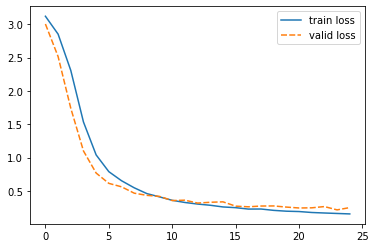

In [169]:
import seaborn as sns

losses_df = pd.DataFrame({'train loss': train_losses, 'valid loss': test_losses})

sns.lineplot(data=losses_df)

<AxesSubplot:>

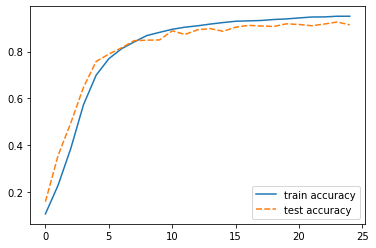

In [170]:
accuracies_df = pd.DataFrame({'train accuracy': torch.Tensor(train_accuracies).to('cpu'), 'test accuracy': torch.Tensor(test_accuracies).to('cpu')})

sns.lineplot(data=accuracies_df)

In [171]:
print(f"Max train accuracy {max(train_accuracies)}, max test accuracy {max(test_accuracies)}")

Max train accuracy 0.9505808353424072, max test accuracy 0.9259868264198303


According to the accuracy lineplot, the model's improvement seems to plateau in between 10 and 20 epochs. Within that range the train and test accuracies start diverge, so it might be better to reduce the number of training iterations. The model's train accuracy is higher than expected, the maximum accuracy achieved is around 95%.

In [172]:
idx_to_class = {i:letter for letter, i in class_to_idx.items()}

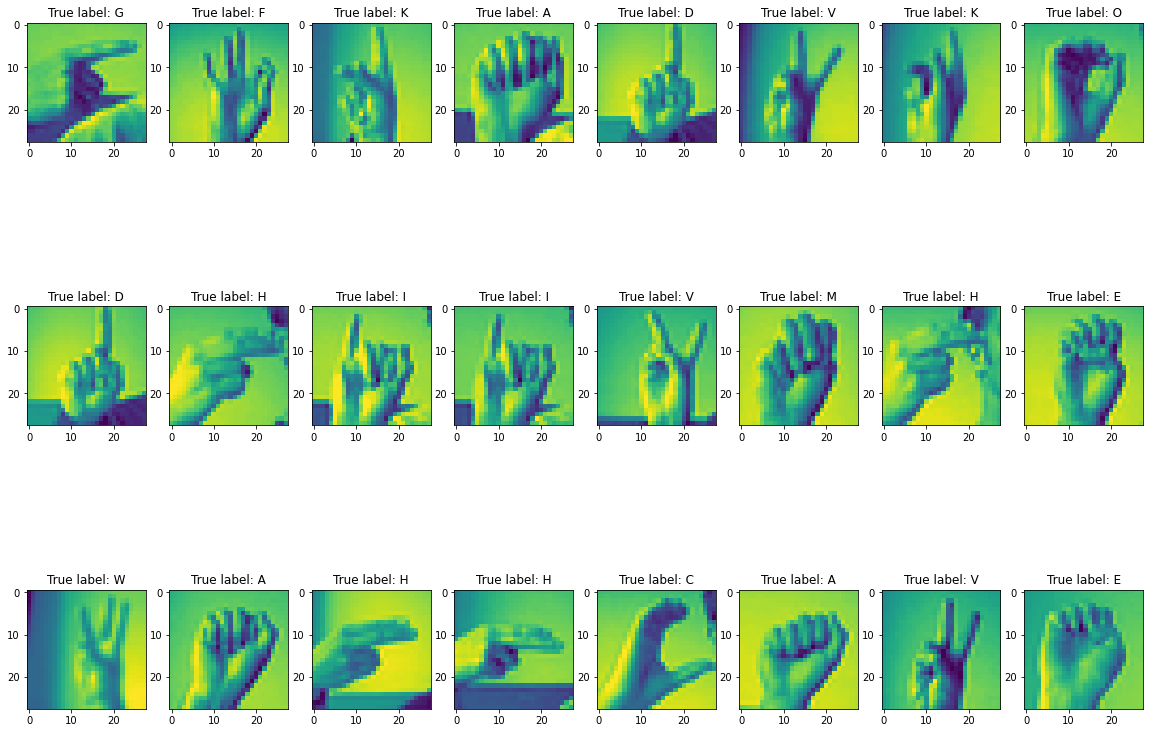

In [173]:
data, label = next(iter(testloader))
predictions = CNN(data.float())
softmax = nn.Softmax(dim=0)
plt.figure(figsize=(20,20))

for i in range(24):
    prob = softmax(predictions[i])
    predicted_label = idx_to_class[int(torch.argmax(prob))]
    true_label = idx_to_class[int(label[i])]
    plt.subplot(4, 8, i+1)
    if predicted_label == true_label:
        plt.title(f"True label: {true_label}", wrap=True)
    else:
        plt.title(f"Predicted Label: {predicted_label}, True label: {true_label}", wrap=True)
    plt.imshow(torch.squeeze(data[i].to('cpu')))
plt.show()

In [181]:
import os 

torch.save(CNN.state_dict(), os.getcwd() + "\\CNNModel.pth")

# Conclusion

My goal for this project was to achieve an accuracy of 80% or higher, and since I have managed to develop a model with an accuracy of around 95% I would say that the goal was reached successfully. There was no need to develop a second model or optimize the hyperparameters. The loss and accuracy plots show some divergence between the train and test results, but not to a significant degree. 